## Introduction

This study develops a content-based recommender system designed to navigate the expansive and intricate domain of academic publications on the arXiv platform. Utilizing semantic embeddings, this system aims to precisely match researchers with papers that align closely with their interests or current research queries, leveraging the nuanced semantic relationships within academic texts.

The process commenced with meticulous data preparation, involving the cleaning and preprocessing of text data to optimize it for processing by a Sentence Transformer. This step was crucial to ensure the quality and relevance of the semantic embeddings generated, which serve as the foundation of our recommendation logic. By encoding the abstracts or titles into dense vector representations, we captured the inherent semantic information of each paper, facilitating a nuanced comparison of their content.
We explored various algorithms to structure and interpret these embeddings effectively. Starting with a basic approach that directly utilized embeddings for recommendations, we advanced to more sophisticated clustering techniques: KMeans and HDBSCAN, each offering unique advantages in grouping semantically similar papers. To further enhance our model, we integrated HDBSCAN with UMAP, a dimensionality reduction technique, to address the challenges posed by high-dimensional data and to refine our clustering outcomes.

Our analysis of the models' effectiveness was comprehensive, employing a series of statistical tests to discern the most proficient method. This included evaluating the models based on normalized hit scores derived from the 'terms' labels of the query and recommended papers, and further statistical comparisons through non-parametric tests to ascertain significant differences among the models. The absence of true labels necessitated a creative approach to evaluation, leading us to utilize metrics such as the Rank-Biased Overlap (RBO) and Kendall's Tau for a nuanced assessment of model performance.
Statistical tests, including T-tests, Mann-Whitney U, Friedman, Nemenyi, and Wilcoxon signed-rank tests, were utilized to compare model performances. These tests provided insights into each model's effectiveness, highlighting KMeans as the most effective in semantic clustering, followed by the combined use of HDBSCAN and UMAP. The analysis underscored the significance of hyperparameter tuning, especially for models like HDBSCAN, and demonstrated the utility of UMAP in managing high-dimensional embeddings.

The study contributes to the field of information retrieval by showcasing a methodology for leveraging semantic embeddings in clustering and recommending academic papers. It highlights the potential of machine learning and natural language processing techniques in improving the accessibility of relevant literature within extensive datasets like arXiv. This approach offers a scalable solution to the challenge of navigating large-scale academic repositories, providing a foundation for future enhancements in recommender system design.


In [1]:
import numpy as np
import torch
import torch.nn as nn
print("CUDA available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=True)
#!pip install matplotlib-venn
from matplotlib_venn import venn3
import seaborn as sns

import pandas as pd
pd.set_option('display.max_colwidth', 50)
pd.options.mode.chained_assignment = None


import importlib
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

CUDA available:  True


In [196]:
#!mkdir arxiv_data

In [197]:
arxiv_data = pd.read_csv("./arxiv_data/arxiv_data_210930-054931.csv")
arxiv_data.head()

,terms,titles,abstracts
0,['cs.LG'],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...
1,"['cs.LG', 'cs.AI']",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...
2,"['cs.LG', 'cs.CR', 'stat.ML']",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...
3,"['cs.LG', 'cs.CR']",Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...
4,['cs.LG'],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...


## Data Cleaning

In [198]:
arxiv_data.describe(include='all').style.set_caption('Summary Statistics')

,terms,titles,abstracts
count,56181,56181,56181
unique,3402,41105,41115
top,['cs.CV'],Deep Reinforcement Learning: An Overview,"Mesh is a powerful data structure for 3D shapes. Representation learning for 3D meshes is important in many computer vision and graphics applications. The recent success of convolutional neural networks (CNNs) for structured data (e.g., images) suggests the value of adapting insight from CNN for 3D shapes. However, 3D shape data are irregular since each node's neighbors are unordered. Various graph neural networks for 3D shapes have been developed with isotropic filters or predefined local coordinate systems to overcome the node inconsistency on graphs. However, isotropic filters or predefined local coordinate systems limit the representation power. In this paper, we propose a local structure-aware anisotropic convolutional operation (LSA-Conv) that learns adaptive weighting matrices for each node according to the local neighboring structure and performs shared anisotropic filters. In fact, the learnable weighting matrix is similar to the attention matrix in the random synthesizer -- a new Transformer model for natural language processing (NLP). Comprehensive experiments demonstrate that our model produces significant improvement in 3D shape reconstruction compared to state-of-the-art methods."
freq,18719,7,7


In [199]:
print("DataFrame shape:", arxiv_data.shape)
print("Data types:", arxiv_data.dtypes)
print("Missing values:", arxiv_data.isnull().sum())

DataFrame shape: (56181, 3)
Data types: terms        object
titles       object
abstracts    object
dtype: object
Missing values: terms        0
titles       0
abstracts    0
dtype: int64


#### Checking for Duplicates

In [200]:
# Check for exact duplicates across all columns
exact_duplicates = arxiv_data[arxiv_data.duplicated()]
# Find duplicates based on 'titles' and 'abstracts' only
title_abstract_duplicates = arxiv_data[arxiv_data.duplicated(subset=['titles', 'abstracts'], keep=False)]
print("Number of exact duplicates:", exact_duplicates.shape[0])
print("Entries with duplicate titles and abstracts:", title_abstract_duplicates.shape[0])

# Investigate duplicates for a specific title
specific_title_duplicates = arxiv_data[arxiv_data['titles'] == "Deep Reinforcement Learning: An Overview"]
print("Occurrences of specific title:", specific_title_duplicates.shape[0])
# Investigate the details of these duplicates
specific_title_duplicates[['terms', 'titles', 'abstracts']]

Number of exact duplicates: 15054
Entries with duplicate titles and abstracts: 27067
Occurrences of specific title: 7


,terms,titles,abstracts
1659,['cs.LG'],Deep Reinforcement Learning: An Overview,We give an overview of recent exciting achieve...
1757,"['cs.LG', 'cs.AI', 'stat.ML']",Deep Reinforcement Learning: An Overview,"In recent years, a specific machine learning m..."
11420,['cs.LG'],Deep Reinforcement Learning: An Overview,We give an overview of recent exciting achieve...
11686,"['cs.LG', 'cs.AI', 'stat.ML']",Deep Reinforcement Learning: An Overview,"In recent years, a specific machine learning m..."
22784,['cs.LG'],Deep Reinforcement Learning: An Overview,We give an overview of recent exciting achieve...
39297,['cs.LG'],Deep Reinforcement Learning: An Overview,We give an overview of recent exciting achieve...
40465,['cs.LG'],Deep Reinforcement Learning: An Overview,We give an overview of recent exciting achieve...


We need to clean the text columns 'titles' and 'abstracts'. So we will use 'patterns' to filter out undesirable signs. The job is done by class 'AbstractProcessor'.

In [201]:
from data_processor import AbstractProcessor

processor = AbstractProcessor()

# Sample patterns to look for special signs
patterns = [
    r'\$.*?\$',  # Inline math expressions enclosed in $
    r'\\[a-zA-Z]+\{.*?\}',  # LaTeX commands
    r'\w+_{[^}]+}',  # Subscripts
    r'\w+\'',  # Primes
    r'\w+_{[^}]+}\'?',  # Subscripts followed by a prime
    r'\w+^{-?\d+}',  # Superscripts
    r'\{[^}]+\}',  # Expressions enclosed in braces
    r'\[[^\]]+\]',  # Expressions enclosed in square brackets
    r'\^'
]
processor.find_special_signs(arxiv_data['abstracts'], patterns=patterns)

{'\\cc{bkmdp97}',
 "DCUR'",
 "dispersion'",
 '{selective}',
 '\\cite{xu2016msr}',
 '{The new insight attributes to an efficient\nreconstruction manner.}',
 "tracker'",
 '\\emph{generalized}',
 '\\textit{Objects}',
 '{\\em distribution free}',
 '$1-2$',
 '$\\times 8, \\times 16$',
 '$\\Omega(\\log (N)H^2SA/\\epsilon^2)$',
 "firefighters'",
 '$1.76\\times$',
 '{\\bf I}',
 '[sub-]',
 '{\\theta}',
 "Zadeh'",
 '\\textbf{adversarial training}',
 '{\\em polynomial-time adaptive}',
 '{\\em fixed}',
 '$O(kn)$',
 "receiver'",
 'CO_{2}',
 '{\\em\npolicy-distribution}',
 '\\emph{center-head point extraction based detector}',
 '{low pass}',
 '[Mildenhall et al. 2020]',
 '${\\cal O}(1/k)$',
 '$0.85 \\pm 0.14$',
 '$H=1$',
 '\\mathbf{b}',
 '$\\frac{1}{m}\\sum\\nolimits_{j = 1}^m G_j(x)$',
 '\\textit{MVFuseNet}',
 '[R_S(W)]',
 '{CUB-200}',
 "categories'",
 '[DA]',
 "law'",
 '{Python}',
 '\\boldsymbol{Y}',
 '$\\text{polylog}\\left(T\\right)$',
 '\\emph{change-point problem}',
 '$b(s,a)$',
 '$F_V$',
 '{S

'AbstractProcessor' also replaces mathematical formulae with '[MATH_EXPR]'.

In [202]:
# Now correctly applies the processor to the 'abstracts' column
arxiv_data['abstracts'] = processor.process(arxiv_data['abstracts'])
processor.find_special_signs(arxiv_data['abstracts'], patterns=patterns)

{'[MATH_EXPR]'}

In [203]:
processor.find_special_signs(arxiv_data['titles'], patterns=patterns)

{'$ β$',
 '$(2)$',
 '$(f,Γ)$',
 '$(σ, λ)$',
 '$1/n$',
 '$2$',
 '$2^D$',
 '$360^\\circ$',
 '$360^o$',
 '$A^2$',
 '$C$',
 '$DA^3$',
 '$E(2)$',
 '$H_\\infty$',
 '$K$',
 '$L2$',
 '$L^2$',
 '$L^p$',
 '$L_0$',
 '$L_1$',
 '$L_2$',
 '$L_{2,0}$',
 '$L_{2,\\infty}$',
 '$N-D$',
 '$O( \\max \\{n_1, n_2 \\}\\log ( \\max \\{ n_1, n_2 \\} n_3) )$',
 '$O(n)$',
 '$P^2$',
 '$Q$',
 '$QD$',
 '$S^3$',
 '$TGV$',
 '$UoI_{LASSO}$',
 '$UoI_{VAR}$',
 '$\\bf{10^{7}}$',
 '$\\ell_0$',
 '$\\ell_1$',
 '$\\ell_4$',
 '$\\ell_\\infty$',
 '$\\ell_p$',
 '$\\ell_{1,p}$',
 '$\\ell_{1}$',
 '$\\ell_{2,\\infty}$',
 '$\\ell_{\\infty}$',
 '$\\hat{\\text{A}}$',
 '$\\leftrightarrow$',
 '$\\mathcal{G}$',
 '$\\mathcal{H}$',
 '$\\mathcal{L}_1$',
 '$\\mathcal{X}$',
 '$\\mathrm{L}^p$',
 '$\\mathtt{MedGraph:}$',
 '$\\sqrt{n}$',
 '$\\times$',
 '$^2$',
 '$^3$',
 '$^5$',
 '$^\\circ$',
 '$^{2}$',
 '$^{3D}$',
 '$^{NET}-$',
 '$^{\\circ}$',
 '$^{\\text{pro}}$',
 '$^{\\text{x}}$',
 '$^θ$',
 '$c^+$',
 '$d$',
 '$e$',
 '$f$',
 '$k$',
 '$l_0$',
 '

In [204]:
arxiv_data['titles'] = processor.process(arxiv_data['titles'])
processor.find_special_signs(arxiv_data['titles'], patterns=patterns)

{'[MATH_EXPR]'}

### Duplicates in 'titles' and 'abstracs' columns

#### Identifying entries where titles are the same but abstracts are different

In [205]:
arxiv_data_sample = arxiv_data
# Using the groupby function to group by titles and then filtering out groups with more than one unique abstract
title_groups = arxiv_data_sample.groupby('titles').filter(lambda x: x['abstracts'].nunique() > 1)

# Displaying the titles that have more than one unique abstract
if not title_groups.empty:
    print("Entries with the same title but different abstracts:")
    print(title_groups[['titles', 'abstracts']])
else:
    print("No entries found with the same title but different abstracts.")

Entries with the same title but different abstracts:
                                                  titles  \
540                                    Point Transformer   
1659            Deep Reinforcement Learning: An Overview   
1757            Deep Reinforcement Learning: An Overview   
3368   Distributed Online Learning with Multiple Kernels   
3576   Distributed Online Learning with Multiple Kernels   
5786   Flow Fields: Dense Correspondence Fields for H...   
6078   Flow Fields: Dense Correspondence Fields for H...   
6722   Flow Fields: Dense Correspondence Fields for H...   
7014   Flow Fields: Dense Correspondence Fields for H...   
7942   Searching Collaborative Agents for Multi-plane...   
9399   Searching Collaborative Agents for Multi-plane...   
10743                 Fairness in Reinforcement Learning   
11420           Deep Reinforcement Learning: An Overview   
11686           Deep Reinforcement Learning: An Overview   
12025                 Fairness in Reinforcement

#### Identifying entries where titles are the same but abstracts are different

In [206]:
arxiv_data_sample = arxiv_data
# Using the groupby function to group by titles and then filtering out groups with more than one unique abstract
abstract_groups = arxiv_data_sample.groupby('abstracts').filter(lambda x: x['titles'].nunique() > 1)

# Displaying the titles that have more than one unique abstract
if not abstract_groups.empty:
    print("Entries with the same abstract but different titles:")
    print(abstract_groups[['titles', 'abstracts']])
else:
    print("No entries found with the same abstract but different titles.")

Entries with the same abstract but different titles:
                                                  titles  \
403                        Stochastic Graphlet Embedding   
450    Graph Kernels based on High Order Graphlet Par...   
2042   Score Function Features for Discriminative Lea...   
2051   Score Function Features for Discriminative Lea...   
5581   DepthTransfer: Depth Extraction from Video Usi...   
5582   Depth Extraction from Video Using Non-parametr...   
6517   DepthTransfer: Depth Extraction from Video Usi...   
6518   Depth Extraction from Video Using Non-parametr...   
32344  Induction of Non-monotonic Logic Programs To E...   
32510  Induction of Non-Monotonic Rules From Statisti...   
40450  Deep unsupervised learning through spatial con...   
40718  Spatial contrasting for deep unsupervised lear...   
45713  DepthTransfer: Depth Extraction from Video Usi...   
45714  Depth Extraction from Video Using Non-parametr...   

                                              

### Drop duplicates where abstracts are the same but titles are different

In [207]:
# Keeping the first occurrence by default
arxiv_data = arxiv_data.drop_duplicates(subset=['abstracts'], keep='first')
# Verify entries with the same titles but different abstracts
title_groups = arxiv_data.groupby('titles').filter(lambda x: x['abstracts'].nunique() > 1)

if not title_groups.empty:
    print("Entries with the same title but different abstracts found:", title_groups.shape[0])
else:
    print("No entries with the same title but different abstracts found.")

Entries with the same title but different abstracts found: 30


In [208]:
arxiv_data.describe()

,terms,titles,abstracts
count,41115,41115,41115
unique,3402,41100,41115
top,['cs.CV'],Parameter Priors for Directed Acyclic Graphica...,Graph neural networks (GNNs) have been widely ...
freq,13156,2,1


This code identifies and analyzes duplicate titles within our dataset, counting the frequency of each unique combination of title, abstract, and terms. It preserves the original row index for each entry to maintain reference to the original data. Finally, it sorts these findings to highlight the most common occurrences of duplicated titles, aiding in data cleaning and analysis of publication patterns.

In [209]:
# Ensure the index is explicitly available as a column
arxiv_data['original_index'] = arxiv_data.index
# Create a mask for duplicated titles
is_duplicated = arxiv_data.duplicated(subset='titles', keep=False)
# Apply the mask and keep the original index along with the data
duplicated_titles = arxiv_data[is_duplicated].copy()
# For each duplicated title, count the frequency of each unique abstract, terms combination
# Here, ensure to group by the original index as well to preserve it
title_abstract_freq = duplicated_titles.groupby(['original_index', 'titles', 'abstracts', 'terms']).size().reset_index(name='Frequency')
# Sort the results for better readability 
# Sorting won't affect the index preservation
title_abstract_freq = title_abstract_freq.sort_values(['titles', 'Frequency'], ascending=[True, False])

pd.set_option('display.max_colwidth', 100)
title_abstract_freq

,original_index,titles,abstracts,terms,Frequency
13,14571,Class-Agnostic Segmentation Loss and Its Application to Salient Object Detection and Segmentation,"In this paper we present a novel loss function, called class-agnostic segmentation (CAS) loss. W...","['cs.CV', 'cs.LG']",1
18,19000,Class-Agnostic Segmentation Loss and Its Application to Salient Object Detection and Segmentation,"In this paper we present a novel loss function, called class-agnostic segmentation (CAS) loss. W...","['cs.CV', 'cs.LG']",1
22,27967,Deep Image Compositing,"In image editing, the most common task is pasting objects from one image to the other and then e...",['cs.CV'],1
23,41415,Deep Image Compositing,Image compositing is a task of combining regions from different images to compose a new image. A...,['cs.CV'],1
1,1659,Deep Reinforcement Learning: An Overview,We give an overview of recent exciting achievements of deep reinforcement learning (RL). We disc...,['cs.LG'],1
2,1757,Deep Reinforcement Learning: An Overview,"In recent years, a specific machine learning method called deep learning has gained huge attract...","['cs.LG', 'cs.AI', 'stat.ML']",1
3,3368,Distributed Online Learning with Multiple Kernels,We consider the problem of learning a nonlinear function over a network of learners in a fully d...,['cs.LG'],1
4,3576,Distributed Online Learning with Multiple Kernels,"In the Internet-of-Things (IoT) systems, there are plenty of informative data provided by a mass...","['cs.LG', 'stat.ML']",1
19,21231,Dynamic Belief Fusion for Object Detection,A novel approach for the fusion of detection scores from disparate object detection methods is p...,['cs.CV'],1
20,21232,Dynamic Belief Fusion for Object Detection,A novel approach for the fusion of heterogeneous object detection methods is proposed. In order ...,['cs.CV'],1


The following removes entries from the arxiv_data dataframe based on a list of indices derived from duplicate title analysis, specifically targeting entries where abstracts are identical but titles differ. It aims to clean the dataset by excluding these redundant entries. After removal, it also drops the helper column used for tracking original indices, ensuring the cleaned dataframe is ready for further analysis or processing.

In [210]:
#we remove data from arxiv_data
# Convert the 'original_index' column in title_abstract_freq to a list of indices to be removed
indices_to_remove = title_abstract_freq['original_index'].tolist()
# Drop these indices from arxiv_data, ie where abstracts are the same but titles diffrent
arxiv_data_filtered = arxiv_data.drop(indices_to_remove)
#arxiv_data_filtered.drop(columns='original_index', inplace=True)
arxiv_data_filtered.drop(arxiv_data_filtered.columns[-1], axis=1, inplace=True)#.loc[540]
arxiv_data_filtered

,terms,titles,abstracts
0,['cs.LG'],Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Mul...,Graph neural networks (GNNs) have been widely used to learn vector representation of graph-struc...
1,"['cs.LG', 'cs.AI']",Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small S...,Deep networks and decision forests (such as random forests and gradient boosted trees) are the l...
2,"['cs.LG', 'cs.CR', 'stat.ML']",Power up! Robust Graph Convolutional Network via Graph Powering,"Graph convolutional networks (GCNs) are powerful tools for graph-structured data. However, they ..."
3,"['cs.LG', 'cs.CR']",Releasing Graph Neural Networks with Differential Privacy Guarantees,With the increasing popularity of Graph Neural Networks (GNNs) in several sensitive applications...
4,['cs.LG'],Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification,Machine learning solutions for pattern classification problems are nowadays widely deployed in s...
...,...,...,...
56173,['stat.ML'],An experimental study of graph-based semi-supervised classification with additional node informa...,"The volume of data generated by internet and social networks is increasing every day, and there ..."
56175,"['stat.ML', 'cs.LG']",Bayesian Differential Privacy through Posterior Sampling,Differential privacy formalises privacy-preserving mechanisms that provide access to a database....
56176,"['cs.CV', 'cs.IR']",Mining Spatio-temporal Data on Industrialization from Historical Registries,"Despite the growing availability of big data in many fields, historical data on socioevironmenta..."
56177,"['cs.LG', 'cs.AI', 'cs.CL', 'I.2.6; I.2.7']",Wav2Letter: an End-to-End ConvNet-based Speech Recognition System,"This paper presents a simple end-to-end model for speech recognition, combining a convolutional ..."


This snippet further cleans the duplicated_titles dataframe by extracting the first three words from each abstract and using this shortened abstract to identify and remove additional duplicates, keeping only the first occurrence of each unique title-abstract combination. It then cleans up by removing the temporary column used for this deduplication process. This approach aims to refine the dataset by eliminating entries that are very similar in both title and the beginning of the abstract, thus reducing redundancy while preserving a diverse set of records.

In [211]:
# Extract the first five words from each abstract in duplicated_titles DataFrame
duplicated_titles['first_five_words'] = duplicated_titles['abstracts'].apply(lambda x: ' '.join(x.split()[:3]))
# Identify and remove duplicates based on the 'first_five_words' column, keeping the first occurrence
# Note: Adjust 'keep' parameter as needed based on which duplicates you want to keep
duplicated_titles_deduplicated = duplicated_titles.drop_duplicates(subset=['titles', 'first_five_words'], keep='first')
# Optionally, you might want to remove the 'first_five_words' column if it's no longer needed
duplicated_titles_deduplicated.drop(['first_five_words', 'original_index'], axis=1, inplace=True)
# duplicated_titles_deduplicated now contains entries from duplicated_titles but with further deduplication based on the first five words of the abstracts
duplicated_titles_deduplicated

,terms,titles,abstracts
540,['cs.CV'],Point Transformer,Self-attention networks have revolutionized natural language processing and are making impressiv...
1659,['cs.LG'],Deep Reinforcement Learning: An Overview,We give an overview of recent exciting achievements of deep reinforcement learning (RL). We disc...
1757,"['cs.LG', 'cs.AI', 'stat.ML']",Deep Reinforcement Learning: An Overview,"In recent years, a specific machine learning method called deep learning has gained huge attract..."
3368,['cs.LG'],Distributed Online Learning with Multiple Kernels,We consider the problem of learning a nonlinear function over a network of learners in a fully d...
3576,"['cs.LG', 'stat.ML']",Distributed Online Learning with Multiple Kernels,"In the Internet-of-Things (IoT) systems, there are plenty of informative data provided by a mass..."
5786,"['cs.CV', 'I.4.8']",Flow Fields: Dense Correspondence Fields for Highly Accurate Large Displacement Optical Flow Est...,Modern large displacement optical flow algorithms usually use an initialization by either sparse...
7942,"['cs.CV', 'cs.MA', 'eess.IV']",Searching Collaborative Agents for Multi-plane Localization in 3D Ultrasound,3D ultrasound (US) has become prevalent due to its rich spatial and diagnostic information not c...
10743,"['cs.LG', 'cs.AI', 'stat.ML']",Fairness in Reinforcement Learning,"Decision support systems (e.g., for ecological conservation) and autonomous systems (e.g., adapt..."
12025,['cs.LG'],Fairness in Reinforcement Learning,"We initiate the study of fairness in reinforcement learning, where the actions of a learning alg..."
13982,"['cs.CV', 'stat.ML']",Partial Membership Latent Dirichlet Allocation,"Topic models (e.g., pLSA, LDA, sLDA) have been widely used for segmenting imagery. However, thes..."



Next we have to iterate over groups of records in duplicated_titles_deduplicated that share the same title. For each group with more than one record (indicating duplicated titles), it generates new unique titles by appending a suffix "_{number}" to the original title. These new titles are then assigned back to the 'titles' column of the respective records in the dataframe, ensuring that each title within the dataset is unique. This process helps in differentiating between different records that originally had identical titles, facilitating easier identification and reference.

In [212]:
# Initialize a new column for updated titles
duplicated_titles_deduplicated_copy = duplicated_titles_deduplicated

# Group by 'titles' and iterate over each group
for title, group in duplicated_titles_deduplicated_copy.groupby('titles'):
    if len(group) > 1:  # Check if the title is repeated
        # Generate new titles with suffixes
        new_titles = [f"{title}_{i+1}" for i in range(len(group))]
        # Update the 'updated_titles' column for the current group
        duplicated_titles_deduplicated_copy.loc[group.index, 'titles'] = new_titles

# Now, duplicated_titles_deduplicated['updated_titles'] contains the titles with suffixes for repetitions
duplicated_titles_deduplicated_copy#.drop(duplicated_titles_deduplicated.columns[3], axis=1, inplace=True)

,terms,titles,abstracts
540,['cs.CV'],Point Transformer_1,Self-attention networks have revolutionized natural language processing and are making impressiv...
1659,['cs.LG'],Deep Reinforcement Learning: An Overview_1,We give an overview of recent exciting achievements of deep reinforcement learning (RL). We disc...
1757,"['cs.LG', 'cs.AI', 'stat.ML']",Deep Reinforcement Learning: An Overview_2,"In recent years, a specific machine learning method called deep learning has gained huge attract..."
3368,['cs.LG'],Distributed Online Learning with Multiple Kernels_1,We consider the problem of learning a nonlinear function over a network of learners in a fully d...
3576,"['cs.LG', 'stat.ML']",Distributed Online Learning with Multiple Kernels_2,"In the Internet-of-Things (IoT) systems, there are plenty of informative data provided by a mass..."
5786,"['cs.CV', 'I.4.8']",Flow Fields: Dense Correspondence Fields for Highly Accurate Large Displacement Optical Flow Est...,Modern large displacement optical flow algorithms usually use an initialization by either sparse...
7942,"['cs.CV', 'cs.MA', 'eess.IV']",Searching Collaborative Agents for Multi-plane Localization in 3D Ultrasound,3D ultrasound (US) has become prevalent due to its rich spatial and diagnostic information not c...
10743,"['cs.LG', 'cs.AI', 'stat.ML']",Fairness in Reinforcement Learning_1,"Decision support systems (e.g., for ecological conservation) and autonomous systems (e.g., adapt..."
12025,['cs.LG'],Fairness in Reinforcement Learning_2,"We initiate the study of fairness in reinforcement learning, where the actions of a learning alg..."
13982,"['cs.CV', 'stat.ML']",Partial Membership Latent Dirichlet Allocation,"Topic models (e.g., pLSA, LDA, sLDA) have been widely used for segmenting imagery. However, thes..."


#### Concat the obtained DataFrame 'duplicated_titles_deduplicated_copy' with our original 'arxiv_data_filtered'

In [213]:
#arxiv_data_filtered.loc[1757]
combined_arxiv = pd.concat([arxiv_data_filtered, duplicated_titles_deduplicated_copy])#, ignore_index=True)
# Assuming combined_data is your DataFrame
are_any_indices_duplicated = combined_arxiv.index.duplicated().any()
if are_any_indices_duplicated:
    print("There are duplicated indices in the DataFrame.")
else:
    print("There are no duplicated indices in the DataFrame.")

There are no duplicated indices in the DataFrame.


In [214]:
combined_arxiv [combined_arxiv .titles == 'Deep Reinforcement Learning: An Overview_2']

,terms,titles,abstracts
1757,"['cs.LG', 'cs.AI', 'stat.ML']",Deep Reinforcement Learning: An Overview_2,"In recent years, a specific machine learning method called deep learning has gained huge attract..."


In [215]:
combined_arxiv.describe()

,terms,titles,abstracts
count,41106,41106,41106
unique,3402,41106,41106
top,['cs.CV'],Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Mul...,Graph neural networks (GNNs) have been widely used to learn vector representation of graph-struc...
freq,13154,1,1


#### The duplicates either among titles or abstracts have been removed successfuly.

## EDA of LABELS in column 'terms'

In [216]:
pd.set_option('display.max_colwidth', 50)

print("DataFrame shape:", combined_arxiv.shape)
print("Data types:", arxiv_data.dtypes)
print("Missing values:", arxiv_data.isnull().sum())

DataFrame shape: (41106, 3)
Data types: terms             object
titles            object
abstracts         object
original_index     int64
dtype: object
Missing values: terms             0
titles            0
abstracts         0
original_index    0
dtype: int64


We are interested in the Exploratory Data Analysis (EDA) of terms (or labels) in a DataFrame column named 'terms', commonly associated with academic or research articles. The aim is to provide a comprehensive overview of the distribution and relationship of terms within a dataset. This EDA is particularly valuable for our arXiv dataset ofpublications, where terms represent subjects, methodologies, or technologies addressed in the articles.
 
If you analyse functions in 'eda.py' you will find that the terms_statistics function begins by ensuring that each entry in the 'terms' column is correctly formatted as a list, even if it was stored as a string representation of a list. This step is vital for consistent data processing. It then proceeds to split and flatten the terms, accounting for terms that might be separated by semicolons or commas, ensuring a uniform representation of each term across the dataset. This preprocessing enables accurate counting and analysis of term occurrences.

The Counter library is utilized to count the occurrences of each term, highlighting the number of unique terms, the terms that appear only once (potentially indicating niche topics or incorrect tags), and the most common labels. This analysis provides insights into the dataset's focus areas and the distribution of topics.

The dashboard_terms function visualizes this analysis through a series of plots:

- Top 40 Most Frequent Terms: A bar plot showcasing the terms with the highest occurrence, offering a visual representation of the dataset's dominant topics.
- Venn Diagram of Top 3 Labels: This diagram visualizes the overlap between the datasets' three most common terms, providing insight into interdisciplinary topics or common combinations of labels.
- Top 20 Primary Categories for 'cs.CV': Through a bar plot, it highlights the primary categories associated with Computer Vision papers, revealing the diversity of subtopics under a major category.
- Pareto Plot of Primary Categories: A bar plot accompanied by a line plot illustrating the cumulative percentage, this plot identifies the 'vital few' primary categories that constitute the majority of the dataset, following the Pareto principle.

This EDA is aimed at uncovering the underlying structure of terms within the dataset, facilitating a deeper understanding of the dataset's thematic focus and guiding further research, data cleaning, or machine learning model development. By visualizing the frequency and relationships of terms, we can identify areas ripe for investigation, collaboration opportunities, or gaps in the literature. Moreover, this analysis can help in refining the dataset for training recommendation systems or classification models by highlighting the terms that significantly contribute to the dataset's informational value.

In [219]:
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=True)
from eda import terms_statistics, dashboard_terms
filtered_combined_arxiv, filtered_term_freq_df, processed_filtered_combined_arxiv = terms_statistics(combined_arxiv)

Number of unique terms: 841
Total number of terms that appear only once: 436
Most common labels: [('cs.CV', 23457), ('cs.LG', 23293), ('stat.ML', 13101), ('cs.AI', 6196), ('eess.IV', 1820), ('cs.RO', 1548), ('cs.CL', 1117), ('cs.NE', 1065), ('cs.GR', 1005), ('math.OC', 618)]
Number of unique terms after filtering: 406


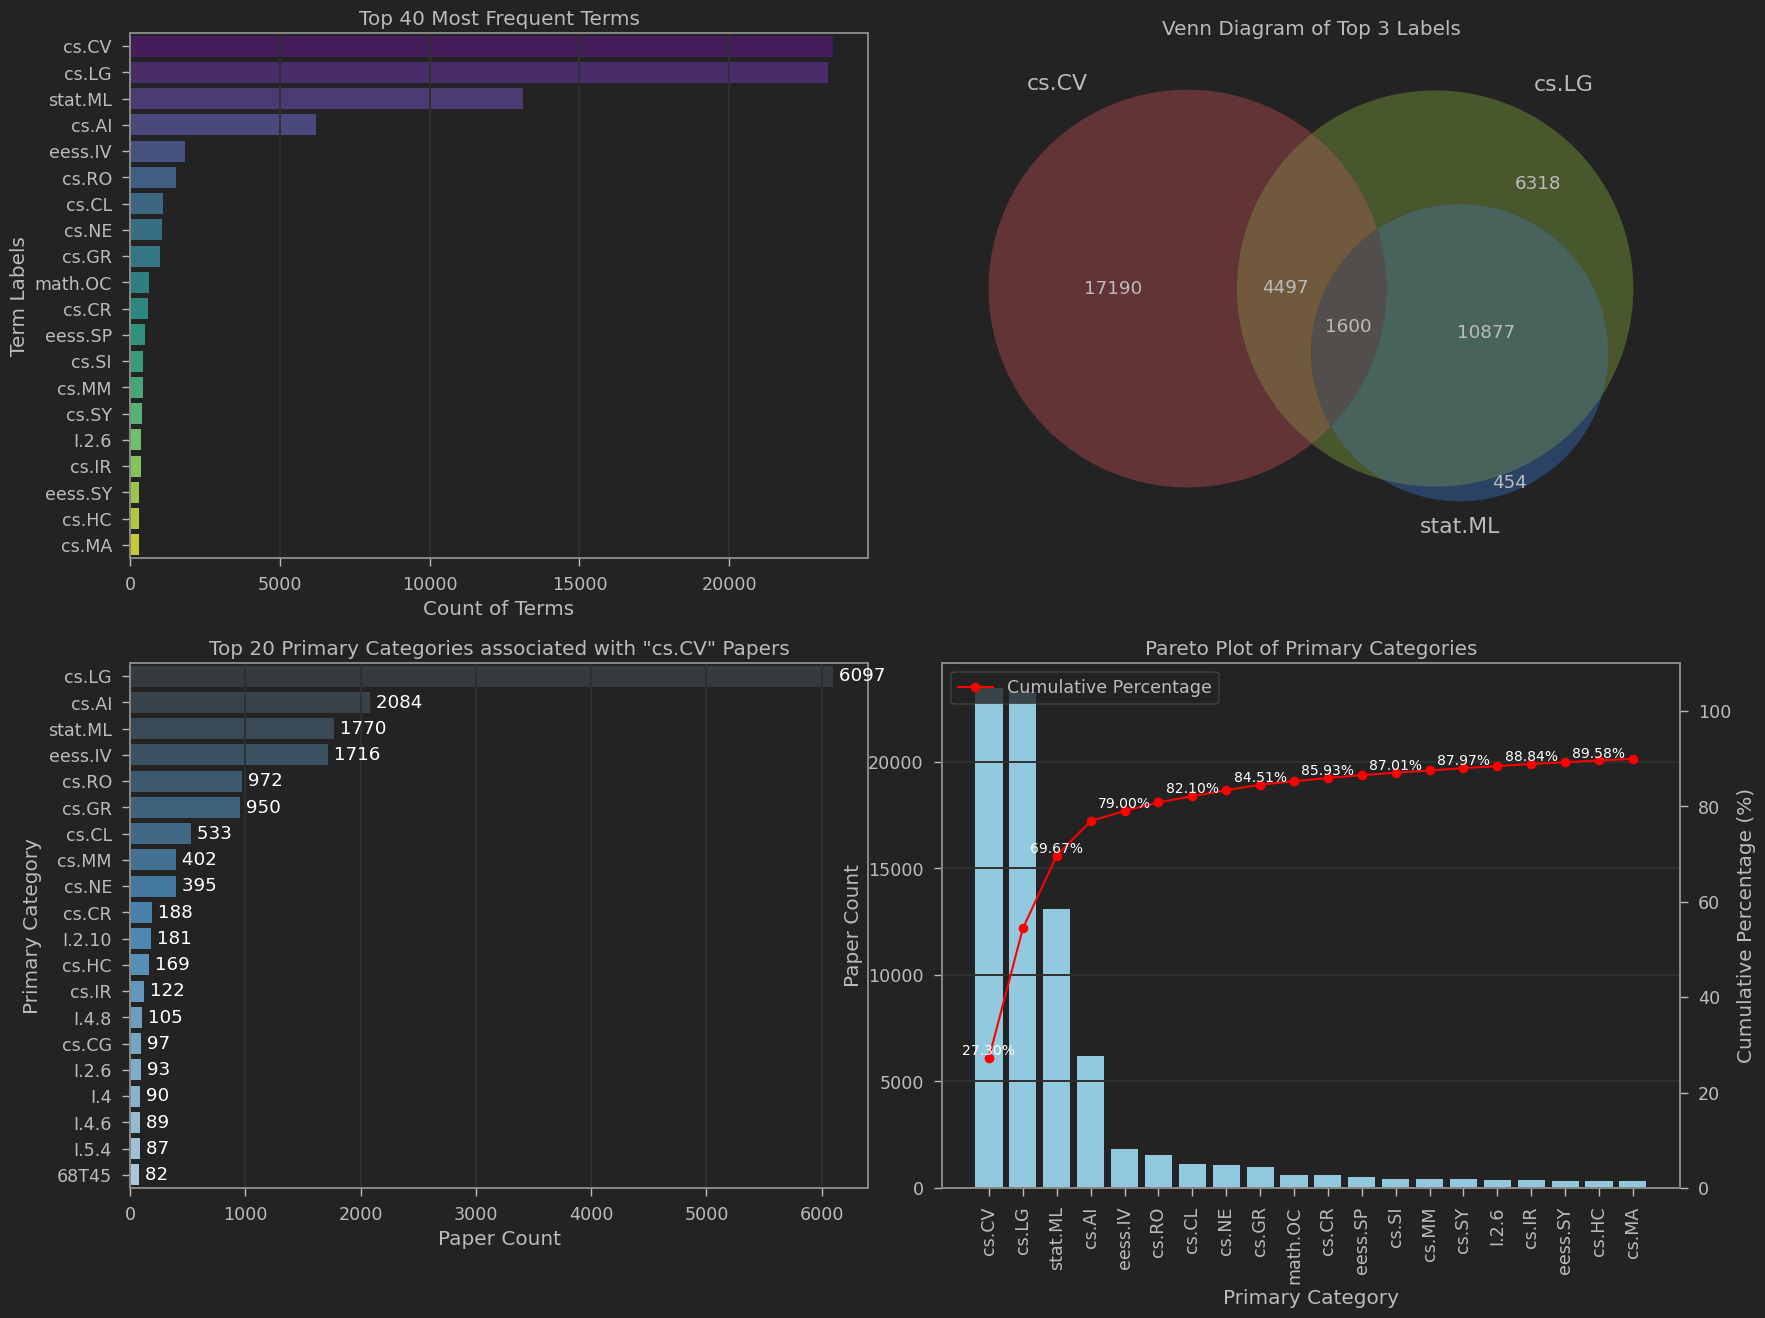

In [220]:
dashboard_terms(filtered_term_freq_df, processed_filtered_combined_arxiv)

The provided image appears to be a collection of visualizations representing the distribution of labels (or "terms") across a dataset of academic papers, with a focus on terms related to computer science, particularly 'cs.CV' (Computer Vision), 'cs.LG' (Machine Learning), and 'stat.ML' (Statistical Machine Learning).

1) Top 40 Most Frequent Terms Bar Plot: This plot shows that 'cs.CV' is the most common label, followed by 'cs.LG' and 'stat.ML'. This indicates that computer vision and machine learning are dominant subjects in the dataset, suggesting that a recommender system for academic papers might be biased towards these topics.
**Impact on Recommender System:** Papers with these labels are likely to be recommended more often, simply due to their prevalence in the dataset. This could create a bias where newer or less common research areas are less likely to be recommended, even if they are more relevant to a user's query.

2) Venn Diagram of Top 3 Labels: The Venn diagram shows significant overlap between 'cs.CV' and 'cs.LG', and to a lesser extent with 'stat.ML'. This suggests a high degree of interdisciplinary research between these fields.
**Influence on Scoring Hits:** When scoring hits for the recommender system, papers that span multiple common categories may receive a higher score, as they resonate with more popular themes. This could lead to an overrepresentation of interdisciplinary papers in recommendations.

3) Top 20 Primary Categories with "cs.CV" Papers Bar Plot: The plot indicates that 'cs.LG' and 'cs.AI' (Artificial Intelligence) are the next most frequent categories associated with 'cs.CV' papers.
**Bias Mitigation:** To decrease bias, the recommender system could employ a normalization technique that accounts for the prevalence of terms. For example, a rarer label could be given more weight in the scoring function, to ensure that papers from less common categories are not overshadowed.

4) Pareto Plot of Primary Categories: The plot demonstrates a Pareto distribution, where a small number of categories account for a large proportion of papers. This indicates that a minority of labels are very common, while the majority are rare.
**Reducing Bias:** The recommender system could be designed to promote diversity in recommendations by including less common labels in the results. This can be achieved by adjusting the ranking algorithm to increase the visibility of papers from underrepresented categories.

### Preparing DataFrame for NLP tasks
We will build the recommender based on dependancies among semantic emebeddings of pretrained Sentence Transformer. On the basis of embedding similarities, the recommender will find $k$ similar papers. Therefore, we have to merge text columns 'titles' and 'abstract' into single column 'text' from which we will derive embeddings. 

In [221]:
processed_filtered_combined_arxiv['text'] = processed_filtered_combined_arxiv['titles'] + ' ' + processed_filtered_combined_arxiv['abstracts']
processed_filtered_combined_arxiv

,titles,abstracts,terms,text
0,"""Best-of-Many-Samples"" Distribution Matching",Generative Adversarial Networks (GANs) can ach...,"[stat.ML, cs.LG]","""Best-of-Many-Samples"" Distribution Matching G..."
1,"""Double-DIP"": Unsupervised Image Decomposition...",Many seemingly unrelated computer vision tasks...,"[cs.LG, cs.CV]","""Double-DIP"": Unsupervised Image Decomposition..."
2,"""Factual"" or ""Emotional"": Stylized Image Capti...",Generating stylized captions for an image is a...,[cs.CV],"""Factual"" or ""Emotional"": Stylized Image Capti..."
3,"""Forget"" the Forget Gate: Estimating Anomalies...",Abnormal event detection is a challenging task...,[cs.CV],"""Forget"" the Forget Gate: Estimating Anomalies..."
4,"""Hey, [MATH_EXPR] ] s not an ODE"": Faster ODE ...",Neural differential equations may be trained b...,"[cs.LG, math.CA]","""Hey, [MATH_EXPR] ] s not an ODE"": Faster ODE ..."
...,...,...,...,...
41101,xUnit: Learning a Spatial Activation Function ...,"In recent years, deep neural networks (DNNs) a...","[cs.LG, cs.CV]",xUnit: Learning a Spatial Activation Function ...
41102,xView: Objects in Context in Overhead Imagery,We introduce a new large-scale dataset for the...,[cs.CV],xView: Objects in Context in Overhead Imagery ...
41103,xYOLO: A Model For Real-Time Object Detection ...,With the emergence of onboard vision processin...,"[eess.IV, stat.ML, cs.RO, cs.LG, cs.CV]",xYOLO: A Model For Real-Time Object Detection ...
41104,"Ω-Net (Omega-Net): Fully Automatic, Multi-View...",Pixelwise segmentation of the left ventricular...,[cs.CV],"Ω-Net (Omega-Net): Fully Automatic, Multi-View..."


In [222]:
processed_filtered_combined_arxiv.to_csv('./arxiv_data/processed_filtered_combined_arxiv.csv')

When you save this DataFrame to a CSV file, these lists are converted to their string representations (e.g., "[cs.LG, cs.AI]") because CSV is a text format that can only store string representations of data. When you read the CSV file back into a DataFrame, these are read as strings, not Python lists. To convert these back to lists, you would need to use ast.literal_eval or a similar method on the terms column after reading the CSV file.

In [223]:
combined_text = pd.read_csv('./arxiv_data/processed_filtered_combined_arxiv.csv', index_col=0, converters={'terms': literal_eval})
combined_text

,titles,abstracts,terms,text
0,"""Best-of-Many-Samples"" Distribution Matching",Generative Adversarial Networks (GANs) can ach...,"[stat.ML, cs.LG]","""Best-of-Many-Samples"" Distribution Matching G..."
1,"""Double-DIP"": Unsupervised Image Decomposition...",Many seemingly unrelated computer vision tasks...,"[cs.LG, cs.CV]","""Double-DIP"": Unsupervised Image Decomposition..."
2,"""Factual"" or ""Emotional"": Stylized Image Capti...",Generating stylized captions for an image is a...,[cs.CV],"""Factual"" or ""Emotional"": Stylized Image Capti..."
3,"""Forget"" the Forget Gate: Estimating Anomalies...",Abnormal event detection is a challenging task...,[cs.CV],"""Forget"" the Forget Gate: Estimating Anomalies..."
4,"""Hey, [MATH_EXPR] ] s not an ODE"": Faster ODE ...",Neural differential equations may be trained b...,"[cs.LG, math.CA]","""Hey, [MATH_EXPR] ] s not an ODE"": Faster ODE ..."
...,...,...,...,...
41101,xUnit: Learning a Spatial Activation Function ...,"In recent years, deep neural networks (DNNs) a...","[cs.LG, cs.CV]",xUnit: Learning a Spatial Activation Function ...
41102,xView: Objects in Context in Overhead Imagery,We introduce a new large-scale dataset for the...,[cs.CV],xView: Objects in Context in Overhead Imagery ...
41103,xYOLO: A Model For Real-Time Object Detection ...,With the emergence of onboard vision processin...,"[eess.IV, stat.ML, cs.RO, cs.LG, cs.CV]",xYOLO: A Model For Real-Time Object Detection ...
41104,"Ω-Net (Omega-Net): Fully Automatic, Multi-View...",Pixelwise segmentation of the left ventricular...,[cs.CV],"Ω-Net (Omega-Net): Fully Automatic, Multi-View..."


In [224]:
print(combined_text['terms'].values[:3])

[list(['stat.ML', 'cs.LG']) list(['cs.LG', 'cs.CV']) list(['cs.CV'])]


In [225]:
from data_processor import multi_bin
df_ready_encoded = multi_bin(combined_text)


Unique labels in 'terms': {'G.1.2', 'cs.DL', 'I.4.5', 'I.3', 'F.2.1', 'cs.DS', 'cs.SE', 'I.0', 'E.3', '49J20', 'gr-qc', 'cs.CV', '11Y16', 'B.7.1', '65C60', '62H30', '60-08', '62G35', '49Q10', 'hep-ph', 'I.2.0', '94A08', '68T99', 'I.5.1', '90C90', 'cs.SC', '86-08', '68T27', 'I.5.5', '37N30', '68R10', 'I.2.9', 'H.3.3', 'nucl-th', 'I.6', '93C41', 'I.2.1', '60L10', '68T07 (Primary) 68T45 (Secondary)', '65Z05', '41A10', 'G.3', 'q-bio.QM', 'physics.comp-ph', '93E35', 'physics.class-ph', 'q-bio.PE', '68W40', '14J60', '68T05 (Primary)', 'cs.LO', '90C35', 'cs.ET', 'math.CA', '49L20 (Secondary)', 'I.4.9', 'I.4', 'cs.LG', 'H.2.4', 'physics.med-ph', 'I.4.10', '68W25', '68U01', 'math.CO', 'cs.SY', '05C99', 'q-fin.RM', 'math-ph', 'I.5.3', 'q-fin.MF', '65D05', '91E40', '42C40', 'cond-mat.mtrl-sci', '05C50', '92C50', '90C27', '68U20', '62G20', '68T10', 'physics.chem-ph', '90C26', '62-07', 'D.1.3', 'G.2.1', 'F.1.3', 'cs.NI', 'stat.CO', '93E10', '68U35', 'astro-ph.GA', '05C85', 'math.GT', 'econ.GN', '6

In [226]:
df_ready_encoded.to_csv('./arxiv_data/df_ready_encoded_arxiv.csv')

In [227]:
print("Number of unique columns:", len(df_ready_encoded.columns[4:].unique()))
print(len(df_ready_encoded.columns[4:])== len(df_ready_encoded.columns[4:].unique()))

Number of unique columns: 406
True


## Recommender System

In [31]:
# Load the entire dataset
df_full = pd.read_csv('./arxiv_data/df_ready_encoded_arxiv.csv', index_col=0, converters={'terms': literal_eval})
n_samples = 10000
df_ready= df_full.sample(n=n_samples, random_state=42)  # Use random_state for reproducibility
df_ready = df_ready.reset_index(drop=True)
df_ready

,titles,abstracts,terms,text,05C50,05C62,05C80,05C85,05C99,11Y16,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,Cyclic Label Propagation for Graph Semi-superv...,Graph neural networks (GNNs) have emerged as e...,[cs.LG],Cyclic Label Propagation for Graph Semi-superv...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Multiview Hessian Regularization for Image Ann...,The rapid development of computer hardware and...,"[stat.ML, cs.LG, cs.CV]",Multiview Hessian Regularization for Image Ann...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Reconfigurable Voxels: A New Representation fo...,LiDAR is an important method for autonomous dr...,[cs.CV],Reconfigurable Voxels: A New Representation fo...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Edge Prior Augmented Networks for Motion Deblu...,Motion deblurring has witnessed rapid developm...,[cs.CV],Edge Prior Augmented Networks for Motion Deblu...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A fast algorithm for complex discord searches ...,Time series analysis is quickly proceeding tow...,[cs.LG],A fast algorithm for complex discord searches ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Lipschitz Parametrization of Probabilistic Gra...,We show that the log-likelihood of several pro...,"[stat.ML, cs.LG]",Lipschitz Parametrization of Probabilistic Gra...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9996,TANet: A new Paradigm for Global Face Super-re...,"Recently, face super-resolution (FSR) methods ...",[cs.CV],TANet: A new Paradigm for Global Face Super-re...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,Content-Aware Inter-Scale Cost Aggregation for...,Cost aggregation is a key component of stereo ...,[cs.CV],Content-Aware Inter-Scale Cost Aggregation for...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,A Novel Focal Tversky loss function with impro...,We propose a generalized focal loss function b...,[cs.CV],A Novel Focal Tversky loss function with impro...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
import os
from sentence_transformers import SentenceTransformer

def save_model_and_embeddings(model, embeddings, model_name, save_path):
    model_path = os.path.join(save_path, model_name)
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    model.save(model_path)

    embeddings_path = os.path.join(model_path, 'embeddings.npy')
    np.save(embeddings_path, embeddings)

#Generate embeddings 
model_1 = SentenceTransformer('bert-base-nli-mean-tokens')
combined_text = df_ready['text'].tolist()
abstract_embeddings = model_1.encode(combined_text, convert_to_tensor=True, device=device).cpu().numpy()

model_save_path = './Saved_models'
save_model_and_embeddings(model_1, abstract_embeddings, 'bert-base-nli-mean-tokens', model_save_path)

In [37]:
import os
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model_name = 'bert-base-nli-mean-tokens'
model_save_path = './Saved_models'
model_path = os.path.join(model_save_path, model_name)
loaded_model = SentenceTransformer(model_path)

embeddings_path = os.path.join(model_path, 'embeddings.npy')
not_norm_loaded_embeddings = np.load(embeddings_path)
not_norm_abstract_embeddings = torch.tensor(not_norm_loaded_embeddings).to(device)

In [38]:
# Check if embeddings are normalized
norms = np.linalg.norm(not_norm_loaded_embeddings, axis=1)
print("Are all embeddings normalized?", np.allclose(norms, np.ones_like(norms)))

#If they are not normalized, you can normalize them as follows:
loaded_embeddings = not_norm_loaded_embeddings / np.linalg.norm(not_norm_loaded_embeddings, axis=1, keepdims=True)
abstract_embeddings = torch.tensor(loaded_embeddings).to(device)

Are all embeddings normalized? False


In [39]:
# Check if embeddings are normalized
norms = np.linalg.norm(loaded_embeddings, axis=1)
print("Are all embeddings normalized?", np.allclose(norms, np.ones_like(norms)))

Are all embeddings normalized? True


UMAP efficiently reduces the high-dimensional embeddings to a lower-dimensional space (2D or 3D) for visualization, preserving the local and global structure of the data. This aids in understanding the intrinsic geometric relationships between points (documents). KMeans clustering identifies natural groupings within the embeddings. These clusters can signify papers with similar topics, research areas, or semantic content, offering insights into the dataset's inherent structure.

In [99]:
from eval import analyze_embeddings
abstract_embeddings_np = abstract_embeddings.cpu().detach().numpy().astype(np.float32) 
analyze_embeddings(embeddings=abstract_embeddings_np, n_neighbors=5, min_dist=0.1, n_components=10, num_clusters=10)#, random_state=123)

In [ ]:
analyze_embeddings(embeddings=abstract_embeddings_np, n_neighbors=50, min_dist=0.1, n_components=50, num_clusters=10)#, random_state=42)

### Explanation of the Recommender System Algorithm

Within the vast expanse of academic literature, particularly in extensive repositories such as arXiv, pinpointing pertinent research papers is akin to finding a needle in a haystack. The recommender system under scrutiny employs an approach to navigate through this high-dimensional haystack to recommend papers that resonate with the semantic content of a user's query.

The system's crux lies in its ability to discern semantic similarity, a feat achieved by representing papers as points in a vector space modeled after their content. This vector space is not just any Euclidean space but one sculpted by the intricate semantics of academic discourse. The mathematical structure of this space is underpinned by embeddings generated from a Sentence Transformer, a neural model adept at capturing the essence of textual data.


Let's denote the entire corpus of papers as $\mathcal{P}$ and a user's query by $q$. Each paper $p \in \mathcal{P}$ and the query $q$ are transmuted into high-dimensional vectors, $\mathbf{v}_p$ and $\mathbf{v}_q$ respectively, through a transformation $\mathcal{T}$ orchestrated by the Sentence Transformer. Formally, this transformation is represented as:

$$
\mathcal{T}: \text{Text} \rightarrow \mathbb{R}^d,
$$

where $d$ is the dimensionality of the embeddings, and $\text{Text}$ is the space of textual content.

Once the query and papers are embedded in this semantic space, their proximity is gauged using cosine similarity, a metric that measures the cosine of the angle between two vectors, thus evaluating their directional alignment rather than magnitude. The cosine similarity between the query vector $\mathbf{v}_q$ and a paper vector $\mathbf{v}_p$ is given by:

$$
\cos(\theta) = \frac{\mathbf{v}_q \cdot \mathbf{v}_p}{\|\mathbf{v}_q\| \|\mathbf{v}_p\|},
$$

where $\theta$ is the angle between $\mathbf{v}_q$ and $\mathbf{v}_p$. A cosine similarity close to 1 indicates a high degree of semantic similarity.

### The Algorithmic Workflow

Upon receiving the query $q$, the recommender system executes the following steps algorithmically:

1. **Embedding the Query**: The query $q$ is encoded into its vector representation $\mathbf{v}_q$.
2. **Computing Similarities**: The cosine similarity between $\mathbf{v}_q$ and every paper vector in the corpus is computed, forming a similarity vector $\mathbf{s}$.
3. **Ranking Papers**: Papers are ranked in descending order of their similarity to the query.
4. **Selecting Top-k Papers**: The top $k$ papers are selected based on this ranking, ensuring the exclusion of the query paper if present in the corpus.

This refined selection mechanism ensures that users are presented with papers that are not just contextually relevant but are also closely aligned with the semantic inquiry posed by their query.

**Pseudocode for the Algorithm:**

```python
def RecommendPapers(query, top_k)
    v_q = Encode(query)
    S = ComputeCosineSimilarities(v_q, CorpusEmbeddings)
    RankedPapers = RankPapers(S)
    TopKPapers = SelectTopK(RankedPapers, top_k)
    return TopKPapers
    end function
```

### K-Means Clustering for Semantic Paper Recommendation

This is the second implemented approach. A recommender system that employs K-Means clustering as its foundational algorithm offers a robust solution to this challenge by harnessing the power of unsupervised learning for semantic grouping.


K-Means clustering operates on the principle of partitioning $n$ observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean. This results in a partitioning of the data space into Voronoi cells. Mathematically, the objective is to find:

$$
\underset{S}{\text{argmin}} \sum_{i=1}^{k} \sum_{\mathbf{x} \in S_i} \|\mathbf{x} - \boldsymbol{\mu}_i\|^2,
$$

where $\mathbf{x}$ represents the data point in the dataset, $\boldsymbol{\mu}_i$ is the mean of points in $S_i$, and $S = \{S_1, S_2, \ldots, S_k\}$ is the set of all clusters.


In the context of paper recommendation, each paper $p$ in the corpus $\mathcal{P}$ is embedded into a vector $\mathbf{v}_p$ using techniques such as TF-IDF or word embeddings, which translate the semantic information of the papers into a mathematical form that can be processed algorithmically.

#### K-Means Algorithm for Semantic Clustering

The recommender system utilizes the K-Means algorithm to semantically cluster papers based on their vector representations. The algorithm proceeds iteratively through the following steps:

1. **Initialization**: Select $k$ initial centroids from the embedded paper vectors.
2. **Assignment**: Assign each paper to the nearest centroid.
3. **Update**: Recalculate the centroids as the mean of the assigned vectors.
4. **Iteration**: Repeat the assignment and update steps until convergence.

The result is a set of clusters, each representing a group of semantically similar papers.

#### Recommendation Strategy

Once papers are clustered, the recommendation process is as follows:

1. **Cluster Identification**: For a given query paper $q$, identify the cluster $C_q$ to which it belongs.
2. **Intra-cluster Ranking**: Within $C_q$, rank papers by their similarity to the centroid $\boldsymbol{\mu}_q$ or another similarity metric.
3. **Top-k Selection**: Select the top $k$ papers from the ranked list within $C_q$ as recommendations.

**Pseudocode for the Algorithm:**

```python
def RecommendPapers(query, top_k):
    C_q = IdentifyCluster(query)
    RankedPapers = RankPapersInCluster(C_q)
    TopKPapers = SelectTopK(RankedPapers, top_k)
    return TopKPapers
```

### HDBSCAN Clustering for Semantic Paper Recommendation


HDBSCAN, or Hierarchical Density-Based Spatial Clustering of Applications with Noise, extends DBSCAN by converting the problem of clustering into a quest for the minimum spanning tree that best captures the data's intrinsic structure. Its objective function can be encapsulated as follows:

$$
\underset{S}{\text{argmin}} \sum_{i=1}^{k} \sum_{\mathbf{x} \in S_i} \text{core-dist}_{\mathbf{x}, MinPts}(\mathbf{x}, \mathbf{\mu}_i),
$$

where $S_i$ symbolizes a cluster within the collection $S$, $\mathbf{x}$ denotes a data point, $\mathbf{\mu}_i$ the centroid of $S_i$, and $\text{core-dist}_{\mathbf{x}, MinPts}$ represents the core distance of $\mathbf{x}$ factoring in a minimum number of points $MinPts$. This core distance is a measure of density reachability of $\mathbf{x}$ from $\mathbf{\mu}_i$, integrating the concept of density directly into the clustering mechanism.

#### Algorithmic Workflow in the Recommender System

The recommender system capitalizes on HDBSCAN to detect semantic clusters in a data-driven manner. The parameters, `min_cluster_size` and `min_samples`, act as the knobs for fine-tuning the algorithm, determining the granularity and coherence of the resultant semantic clusters.

The process is executed as follows:

1. **Density Estimation**: The algorithm estimates the density of data points in the embedding space, identifying regions dense with semantic content.
2. **Core Points Identification**: It pinpoints core points that anchor the clusters, similar to seminal research papers defining a research domain.
3. **MinPts Configuration**: The `min_samples` parameter, or MinPts, specifies the density threshold for a point to be considered a core point.
4. **Hierarchical Clustering**: A dendrogram is constructed, capturing the nested relationships between clusters, reminiscent of the hierarchical structure of research fields.
5. **Dendrogram Condensation**: The algorithm condenses the dendrogram, trimming outlier clusters that fail to satisfy the density criterion.
6. **Cluster Extraction**: The final clusters are extracted, each signifying a distinct concentration of research within the academic corpus.


The `recommend_papers_hdbscan` function ries to encapsulate the strength of the HDBSCAN algorithm in recommending semantically related papers. It proceeds through the following intricate steps:

1. **Query Vectorization**: The query paper is converted into a high-dimensional vector $\mathbf{v}_q$ through the SentenceTransformer model.
2. **Cluster Determination**: The system identifies the hierarchical cluster to which the query belongs.
3. **Centroid-Based Ranking**: Within the cluster, papers are ranked based on their cosine similarity to the centroid, ensuring semantic congruence with the query.
4. **Noise Assimilation**: Papers labeled as noise are reassigned to the closest clusters, broadening the recommendation scope.
5. **Top-k Paper Retrieval**: The top $k$ papers are selected from the ranked list, furnishing the user with the most pertinent recommendations.

The detailed pseudocode for the algorithm is as follows:

```python
def perform_clustering_HDBSCAN(embeddings):
    hdbscan_clusterer = HDBSCAN(min_cluster_size=20, min_samples=2, cluster_selection_method='eom')
    cluster_labels = hdbscan_clusterer.fit_predict(embeddings)
    cluster_probabilities = hdbscan_clusterer.probabilities_
    centroids = compute_centroids(cluster_labels, embeddings)
    reassign_noise_points(cluster_labels, centroids, embeddings)
    hierarchical_labels = perform_shallow_hierarchical_clustering(centroids)
    return cluster_labels, cluster_probabilities, hierarchical_labels

def compute_centroids(labels, embeddings):
    centroids = []
    for cluster_id in set(labels):
        if cluster_id != -1:
            cluster_points = embeddings[labels == cluster_id]
            centroid = np.mean(cluster_points, axis=0)
            centroids.append(centroid)
    return np.array(centroids)

def reassign_noise_points(labels, centroids, embeddings):
    noise_indices = np.where(labels == -1)[0]
    if noise_indices.size > 0:
        noise_points = embeddings[noise_indices]
        closest_clusters = find_nearest_clusters(noise_points, centroids)
        for idx, cluster_idx in zip(noise_indices, closest_clusters):
            labels[idx] = cluster_idx
```

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) stands out for its ability to identify clusters of varying densities while aptly managing noise. An integral part of refining the clustering outcome involves computing centroids for the identified clusters and reassigning noise points to enhance the cohesion and interpretability of the clustering solution. Below, we delve into the mathematical underpinnings and procedural steps for these critical tasks.


The centroid $\mathbf{\mu}_i$ of a cluster $C_i$ is central to understanding the cluster's overall direction or trend. In the context of HDBSCAN, where $C = \{C_1, C_2, \ldots, C_k\}$ represents the set of clusters identified (excluding noise points labeled as $-1$), the centroid calculation is as follows:

$$
\mathbf{\mu}_i = \frac{1}{|C_i|} \sum_{\mathbf{x} \in C_i} \mathbf{x},
$$

where $|C_i|$ denotes the cardinality or the number of points in cluster $C_i$, and $\mathbf{x}$ represents the points within cluster $C_i$. This formula calculates the mean position of all points in a cluster, providing a 'central' point that characterizes the cluster's overall position in the data space.


Noise points, by their initial designation in HDBSCAN, do not belong to any cluster. However, their reassignment to the nearest cluster based on centroid proximity can often yield a more comprehensive clustering schema. For each noise point $\mathbf{x}_n$, we determine its nearest cluster by identifying the closest centroid $\mathbf{\mu}_i$:

$$
\text{assign}(\mathbf{x}_n) = \underset{i}{\text{argmin}} \, \|\mathbf{x}_n - \mathbf{\mu}_i\|,
$$

where $\|\mathbf{x}_n - \mathbf{\mu}_i\|$ represents the Euclidean distance between the noise point $\mathbf{x}_n$ and the centroid $\mathbf{\mu}_i$. Through this reassignment process, noise points that are spatially closer to a particular cluster than to others are integrated into that cluster, thus potentially reducing the overall 'noise' in the dataset and enhancing the interpretability of the clustering results.

This methodology not only optimizes the utility of HDBSCAN in discerning dense clusters within the data but also ensures that outliers or noise points are judiciously considered for inclusion in the nearest clusters, thereby refining the granularity and accuracy of the clustering outcome.


### HDBSCAN with UMAP for High-Dimensional Semantic Embeddings

HDBSCAN clustering combined with UMAP dimensionality reduction emerges as a powerful technique to enhance the semantic clustering of papers. This essay delineates the synergistic integration of HDBSCAN and UMAP within a recommender system and elucidates the advantages of UMAP in processing semantic embeddings.

#### The Convergence of HDBSCAN and UMAP - Why UMAP?

UMAP, or Uniform Manifold Approximation and Projection, is an innovative dimensionality reduction technique that is particularly beneficial for high-dimensional data. It is founded on manifold learning and topological structures, facilitating the retention of local and global data structure. In the context of semantic embeddings, UMAP serves a pivotal role:

- **Preserving Local Structures**: It maintains the local proximities of data points, ensuring that semantically similar papers remain close in the reduced space.
- **Revealing Global Patterns**: UMAP uncovers broader patterns and groupings in the data, providing a macroscopic view of the semantic landscape.
- **Enhancing Cluster Formation**: By reducing dimensions while preserving the intrinsic geometric structure, UMAP aids HDBSCAN in detecting denser and more distinct clusters.
- **Accelerating Computation**: Lower-dimensional data lead to faster processing times, making it feasible to apply HDBSCAN to large corpora of academic papers.


UMAP's mathematical foundation is rooted in Riemannian geometry and algebraic topology, particularly focusing on the concepts of simplicial complexes and fuzzy topological structures. The goal of UMAP is to find a low-dimensional representation of the data that approximates the high-dimensional topological structure:

$$
\text{UMAP}(\mathbf{X}) \approx \text{Topology}(\mathbf{X}),
$$

where $\mathbf{X}$ represents the high-dimensional data.

Subsequently, HDBSCAN explores the density-connected clusters within this topologically informed, reduced space, optimizing the following objective:

$$
\underset{S}{\text{argmin}} \sum_{i=1}^{k} \sum_{\mathbf{x} \in S_i} \text{core-dist}_{\mathbf{x}, MinPts}(\mathbf{x}, \mathbf{\mu}_i),
$$

where $S_i$ denotes a cluster, $\mathbf{x}$ is a point in the dataset, $\mathbf{\mu}_i$ is the cluster's centroid, and $\text{core-dist}_{\mathbf{x}, MinPts}$ is the core distance of $\mathbf{x}$ with respect to a minimum number of points $MinPts$.

#### Implementing HDBSCAN with UMAP in a Recommender System

The recommender system weaves together UMAP and HDBSCAN to provide precise and meaningful recommendations. The algorithm proceeds through the following steps:

1. **Dimensionality Reduction**: Apply UMAP to reduce the dimensions of the semantic embeddings, enhancing tractability and cluster distinction.
2. **Density-based Clustering**: Perform HDBSCAN on the reduced embeddings to identify semantically dense clusters of papers.
3. **Centroid Calculation**: Compute the centroids of the identified clusters in the reduced space to anchor the clusters.
4. **Noise Integration**: Reassign noise points to the nearest clusters, incorporating a broader spectrum of papers.
5. **Hierarchical Clustering**: Execute shallow hierarchical clustering on the centroids to discern broader categories within the academic discourse.
6. **Label Mapping**: Map the hierarchical labels back to the original papers, preserving the high-level structure.

The detailed pseudocode for the algorithm is as follows:

```python
def perform_clustering_HDBSCAN_UMAP(embeddings):
    # Reduce dimensionality with UMAP
    embeddings_reduced = UMAP(n_neighbors=44, min_dist=0.1, n_components=35, metric='cosine').fit_transform(embeddings)
    # Cluster with HDBSCAN
    hdbscan_clusterer = HDBSCAN(min_cluster_size=17, min_samples=2, cluster_selection_method='eom')
    cluster_labels = hdbscan_clusterer.fit_predict(embeddings_reduced)
    cluster_probabilities = hdbscan_clusterer.probabilities_
    # Compute centroids
    centroids = compute_centroids(cluster_labels, embeddings_reduced)
    # Reassign noise points
    reassign_noise_points(cluster_labels, centroids, embeddings_reduced)
    # Hierarchical clustering
    shallow_labels = perform_shallow_hierarchical_clustering(centroids)
    return cluster_labels, cluster_probabilities, shallow_labels

def compute_centroids(labels, embeddings_reduced):
    centroids = []
    for cluster_id in set(labels):
        if cluster_id != -1:
            cluster_points = embeddings_reduced[labels == cluster_id]
            centroid = np.mean(cluster_points, axis=0)
            centroids.append(centroid)
    return np.array(centroids)

def reassign_noise_points(labels, centroids, embeddings_reduced):
    noise_indices = np.where(labels == -1)[0]
    if noise_indices.size > 0:
        noise_points = embeddings_reduced[noise_indices]
        closest_clusters = find_nearest_clusters(noise_points, centroids)
        for idx, cluster_idx in zip(noise_indices, closest_clusters):
            labels[idx] = cluster_idx
```

In conclusion, the integration of HDBSCAN with UMAP for semantic paper recommendation leverages the strengths of both algorithms, offering a recommender system that is not only accurate in its semantic delineations but also efficient in its computational performance.


In [42]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

from hdbscan import HDBSCAN
from umap import UMAP

np.random.seed(123)

In [73]:
class RecommenderSystem:
    def __init__(self, model, embeddings, df, num_clusters=5, num_neighbours=2):
        self.model = model
        self.embeddings = embeddings
        self.df = df
        self.num_clusters = num_clusters
        self.num_neighbours = num_neighbours
        self.perform_clustering() #for K-means
        self.perform_clustering_HDBSCAN()

    ################################################# Basic Recommender ############################################################

    def recommend_papers(self, query_title, top_k=5):
        '''The method ranks the entire dataset of papers by their similarity to the query paper, then filters out the query
          paper itself and any duplicates based on titles, ensuring that the top recommendations are unique.'''
        # Embed the query title using the pre-trained model to get its vector representation.
        query_embedding = self.model.encode([query_title], convert_to_tensor=True, device='cpu')
        # Calculate cosine similarity between the query embedding and all other paper embeddings
        similarities = cosine_similarity(query_embedding.cpu().detach().numpy(), self.embeddings.cpu().detach().numpy())
        # Get indices of the papers sorted by their similarity scores in descending order.
        sorted_indices = np.argsort(similarities[0])[::-1]
        # Select papers based on the sorted indices, effectively ranking them by similarity.
        papers = self.df.iloc[sorted_indices]
        # Filter out the query title itself to avoid recommending the paper used as the query.
        papers = papers[papers['titles'] != query_title]
        # Remove duplicates to ensure each recommended paper is unique, and limit the list to the top k results.
        unique_papers = papers.drop_duplicates(subset=['titles']).head(top_k)
        # Return the top-k unique papers as recommendations.
        return unique_papers

    #############################################For the both subsequent algos #######################################
    
    def perform_clustering(self):
        '''Initialize a KMeans clusterer with a predefined number of clusters
            both for recommend_papers_with_kmeans_and_intra_cluster_ranking and 
            recommend_papers_with_intra_cluster_nn'''
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=0)
        # Fit the KMeans model on the embeddings of the papers, clustering them into distinct groups.
        kmeans.fit(self.embeddings.cpu().detach().numpy().astype(np.float32))
        # Assign each paper to a cluster based on the KMeans model's labels
        self.df['cluster'] = kmeans.labels_


    ####################################################### K-Means #################################################
    def recommend_papers_kmeans(self, query_title, top_k=5):
        '''this process first clusters all papers based on their embeddings to group similar topics or content together.
          Then, for a given query, it identifies the cluster containing the query paper, ranks papers within that cluster
            by their similarity to the query, and returns the top k similar papers as recommendations. This approach
              narrows down the search space to more relevant papers by leveraging cluster-based similarity, potentially
                improving recommendation quality.'''
        # Check if the query title exists in the dataset.
        if query_title not in self.df['titles'].values:
            return f"No papers found for the title: {query_title}"
        # Encode the query title to get its embedding.
        query_embedding = self.model.encode([query_title], convert_to_tensor=True, device='cpu').cpu().detach().numpy()
        # Find the index and cluster of the query paper.
        query_index = self.df[self.df['titles'] == query_title].index[0]
        query_cluster = self.df.iloc[query_index]['cluster']
        # Select papers from the same cluster as the query.
        cluster_papers = self.df[self.df['cluster'] == query_cluster]
        # Extract embeddings for papers in the same cluster.
        cluster_embeddings = self.embeddings.cpu().detach().numpy()[cluster_papers.index]
        # Calculate cosine similarity between the query and each paper in the cluster.
        cluster_similarities = cosine_similarity(query_embedding, cluster_embeddings).flatten()
          # Add similarity scores to the cluster papers and sort them by similarity in descending order.
        cluster_papers_ranked = cluster_papers.copy()
        cluster_papers_ranked['similarity'] = cluster_similarities
        cluster_papers_ranked = cluster_papers_ranked.sort_values(by='similarity', ascending=False)

        cluster_papers_ranked = cluster_papers_ranked.drop_duplicates(subset=['titles'])
        unique_papers = cluster_papers_ranked.head(top_k)

        return unique_papers
    
    ####################################################### HDBSCAN ####################################################
    
    def perform_clustering_HDBSCAN(self):
        # Perform density-based clustering with HDBSCAN
        #hdbscan_clusterer = HDBSCAN(min_cluster_size=20, min_samples=5, cluster_selection_method='eom', gen_min_span_tree=False)
        hdbscan_clusterer = HDBSCAN(min_cluster_size=20, min_samples=2, cluster_selection_method='eom', gen_min_span_tree=False)#, prediction_data=True)
        #hdbscan_clusterer = HDBSCAN(min_cluster_size=10, min_samples=5, gen_min_span_tree=True)
        self.df['cluster_hdbscan'] = hdbscan_clusterer.fit_predict(self.embeddings.cpu().detach().numpy().astype(np.float32))
        # Save cluster membership strengths (probabilities)
        self.df['cluster_hdbscan_probabilities'] = hdbscan_clusterer.probabilities_
        # Compute centroids for each cluster except noise
        centroids = self.compute_centroids(hdbscan_clusterer.labels_)
        # Handle noise points by finding the nearest cluster centroid and reassigning them
        self.reassign_noise_points(hdbscan_clusterer.labels_, centroids)
        # Perform shallow hierarchical clustering on centroids
        Z = linkage(centroids, method='ward')
        # Limit to a shallow hierarchy (e.g., 2 levels)
        max_clusters = 4  # Example: aiming for a simple division into 4 broad clusters
        shallow_hierarchical_labels = fcluster(Z, t=max_clusters, criterion='inconsistent')
        # Map shallow hierarchical labels back to the original data points
        for cluster_id, h_label in zip(set(self.df['cluster_hdbscan']), shallow_hierarchical_labels):
            self.df.loc[self.df['cluster_hdbscan'] == cluster_id, 'hierarchical_cluster'] = h_label

    def compute_centroids(self, labels):
        '''This function calculates the centroids of clusters formed by the HDBSCAN algorithm'''
        centroids = []
        for cluster_id in set(labels):
            if cluster_id != -1:  # Exclude noise points
                cluster_points = self.embeddings[labels == cluster_id]
                # If cluster_points is a PyTorch tensor, convert it to a NumPy array before applying np.mean()
                if isinstance(cluster_points, torch.Tensor):
                    cluster_points = cluster_points.cpu().numpy()
                centroid = np.mean(cluster_points, axis=0)
                centroids.append(centroid)
        return np.array(centroids)

    def reassign_noise_points(self, labels, centroids):
        '''After identifying the centroids, this function addresses the noise points. Noise points are those
          that HDBSCAN couldn't confidently assign to any cluster. The function finds the nearest cluster centroid
            for each noise point and reassigns the noise point to that cluster. '''
        noise_indices = np.where(labels == -1)[0]
        if len(noise_indices) > 0:
            # Ensure noise_points is a CPU tensor before converting to NumPy array
            if isinstance(self.embeddings, torch.Tensor):
                # If embeddings are a tensor, extract noise_points as a NumPy array
                noise_points = self.embeddings[noise_indices].cpu().numpy()
            else:
                # If embeddings are already a NumPy array, proceed directly
                noise_points = self.embeddings[noise_indices]

            closest_clusters, _ = pairwise_distances_argmin_min(noise_points, centroids)
            for idx, cluster_idx in zip(noise_indices, closest_clusters):
                self.df.at[idx, 'cluster_hdbscan'] = cluster_idx

    def recommend_papers_hdbscan(self, query_title, top_k=5):
        if query_title not in self.df['titles'].values:
            return pd.DataFrame(columns=self.df.columns)

        # Encode query title to tensor and ensure it's in 2D
        query_embedding_tensor = self.model.encode([query_title], convert_to_tensor=True).to(device)
        query_embedding = query_embedding_tensor.cpu().detach().numpy().reshape(1, -1)
        query_index = self.df[self.df['titles'] == query_title].index[0]
        # Use hierarchical cluster for selecting papers
        query_cluster = self.df.iloc[query_index]['hierarchical_cluster']
        cluster_papers_indices = self.df[self.df['hierarchical_cluster'] == query_cluster].index
        # Ensure cluster_embeddings extraction accounts for potential changes in indexing
        cluster_embeddings = self.embeddings[cluster_papers_indices.tolist()] if isinstance(self.embeddings, torch.Tensor) else self.embeddings[cluster_papers_indices]
        if isinstance(cluster_embeddings, torch.Tensor):
            cluster_embeddings = cluster_embeddings.cpu().numpy()

        # Compute cosine similarities
        similarities = cosine_similarity(query_embedding, cluster_embeddings)
        cluster_papers = self.df.loc[cluster_papers_indices].copy()
        cluster_papers['similarity'] = similarities.flatten()

        # Integrate cluster membership strengths into the ranking, if applicable
        if 'cluster_hdbscan_probabilities' in cluster_papers:
            cluster_papers['weighted_similarity'] = cluster_papers['similarity'] * cluster_papers['cluster_hdbscan_probabilities'].fillna(0)
            recommendations = cluster_papers.sort_values(by='weighted_similarity', ascending=False).head(top_k)
        else:
            recommendations = cluster_papers.sort_values(by='similarity', ascending=False).head(top_k)

        return recommendations

    ###################################################### HDBSCAN + UMAP ######################################################################################
    
    def perform_clustering_HDBSCAN_UMAP(self):

        # Step 1: Reduce dimensionality with UMAP
        self.embeddings_reduced = UMAP(n_neighbors=44, min_dist=0.1, n_components=35, metric='cosine').fit_transform(self.embeddings.cpu().detach().numpy())
        # Step 2: Perform density-based clustering with HDBSCAN on reduced embeddings
        hdbscan_clusterer = HDBSCAN(min_cluster_size=17, min_samples=2, cluster_selection_method='eom', gen_min_span_tree=False)
        self.df['cluster_hdbscan_umap'] = hdbscan_clusterer.fit_predict(self.embeddings_reduced)
        self.df['cluster_hdbscan_probabilities_umap'] = hdbscan_clusterer.probabilities_
        # Step 3: Compute centroids for each cluster except noise in the reduced space
        centroids = self.compute_centroids(hdbscan_clusterer.labels_, use_reduced=True)  # Make sure to adjust compute_centroids to use reduced embeddings
        # Step 4: Handle noise points by finding the nearest cluster centroid and reassigning them
        self.reassign_noise_points(hdbscan_clusterer.labels_, centroids)
        # Step 5: Perform shallow hierarchical clustering on centroids
        Z = linkage(centroids, method='ward')
        max_clusters = 6
        shallow_hierarchical_labels = fcluster(Z, t=max_clusters, criterion='inconsistent')
        # Step 6: Map shallow hierarchical labels back to the original data points
        for cluster_id, h_label in zip(set(self.df['cluster_hdbscan_umap']), shallow_hierarchical_labels):
            self.df.loc[self.df['cluster_hdbscan_umap'] == cluster_id, 'hierarchical_cluster'] = h_label

    def compute_centroids(self, labels):
        centroids = []
        for cluster_id in set(labels):
            if cluster_id != -1:  # Exclude noise points
                cluster_points = self.embeddings[labels == cluster_id]
                # If cluster_points is a PyTorch tensor, convert it to a NumPy array before applying np.mean()
                if isinstance(cluster_points, torch.Tensor):
                    cluster_points = cluster_points.cpu().numpy()
                centroid = np.mean(cluster_points, axis=0)
                centroids.append(centroid)
        return np.array(centroids)

    def reassign_noise_points(self, labels, centroids):
        noise_indices = np.where(labels == -1)[0]
        if len(noise_indices) > 0:
            # Ensure noise_points is a CPU tensor before converting to NumPy array
            if isinstance(self.embeddings, torch.Tensor):
                # If embeddings are a tensor, extract noise_points as a NumPy array
                noise_points = self.embeddings[noise_indices].cpu().numpy()
            else:
                # If embeddings are already a NumPy array, proceed directly
                noise_points = self.embeddings[noise_indices]

            closest_clusters, _ = pairwise_distances_argmin_min(noise_points, centroids)
            for idx, cluster_idx in zip(noise_indices, closest_clusters):
                self.df.at[idx, 'cluster_hdbscan'] = cluster_idx

    def recommend_papers_hdbscan_umap(self, query_title, top_k=5):
        if query_title not in self.df['titles'].values:
            return pd.DataFrame(columns=self.df.columns)

        # Encode query title to tensor and ensure it's in 2D
        query_embedding_tensor = self.model.encode([query_title], convert_to_tensor=True).to(device)
        query_embedding = query_embedding_tensor.cpu().detach().numpy().reshape(1, -1)
        query_index = self.df[self.df['titles'] == query_title].index[0]
        # Use hierarchical cluster for selecting papers
        query_cluster = self.df.iloc[query_index]['hierarchical_cluster']
        cluster_papers_indices = self.df[self.df['hierarchical_cluster'] == query_cluster].index
        # Ensure cluster_embeddings extraction accounts for potential changes in indexing
        cluster_embeddings = self.embeddings[cluster_papers_indices.tolist()] if isinstance(self.embeddings, torch.Tensor) else self.embeddings[cluster_papers_indices]
        if isinstance(cluster_embeddings, torch.Tensor):
            cluster_embeddings = cluster_embeddings.cpu().numpy()

        # Compute cosine similarities
        similarities = cosine_similarity(query_embedding, cluster_embeddings)
        cluster_papers = self.df.loc[cluster_papers_indices].copy()
        cluster_papers['similarity'] = similarities.flatten()

        # Integrate cluster membership strengths into the ranking, if applicable
        if 'cluster_hdbscan_probabilities_umap' in cluster_papers:
            cluster_papers['weighted_similarity'] = cluster_papers['similarity'] * cluster_papers['cluster_hdbscan_probabilities_umap'].fillna(0)
            recommendations = cluster_papers.sort_values(by='weighted_similarity', ascending=False).head(top_k)
        else:
            recommendations = cluster_papers.sort_values(by='similarity', ascending=False).head(top_k)

        return recommendations
    ####################################################### COUNTERS ##################################################

    def hit_counter(self, recommend_func, query_title, top_k=5):
        unique_papers = recommend_func(query_title, top_k)
        # Check if unique_papers is None or an empty DataFrame
        if unique_papers is None or unique_papers.empty:
            return [], 0  # Return empty list and zero score if no papers were recommended

        query_terms = set(self.df[self.df['titles'] == query_title]['terms'].iloc[0])
        unique_papers['matching_terms_count'] = unique_papers['terms'].apply(
            lambda terms: sum(term in query_terms for term in terms))
        recommended_papers_list = unique_papers.apply(
            lambda x: f"'{x['titles']}' {x['terms']} (Matching Terms: {x['matching_terms_count']})", axis=1).tolist()
        formatted_recommendations = "\n".join(recommended_papers_list)
        total_score = unique_papers['matching_terms_count'].sum()
        return formatted_recommendations, total_score

    def hit_counter_norm(self, recommend_func, query_title, top_k=5):
        unique_papers = recommend_func(query_title, top_k)
        if unique_papers.empty or unique_papers is None:
            return [], 0  # Return empty list and zero score if no papers were recommended

        query_terms = set(self.df[self.df['titles'] == query_title]['terms'].iloc[0])
        query_terms_count = len(query_terms)
        total_normalized_score = 0
        # Initialize a column for normalized scores
        unique_papers['normalized_score'] = 0
        for index, paper in unique_papers.iterrows():
            paper_terms = set(paper['terms'])
            paper_terms_count = len(paper_terms)
            matching_terms_count = sum(term in query_terms for term in paper_terms)
            normalized_score = matching_terms_count / max(query_terms_count, paper_terms_count)
            total_normalized_score += normalized_score
            # Update the 'normalized_score' for the current paper
            unique_papers.at[index, 'normalized_score'] = normalized_score
        # Now use the 'normalized_score' column to generate the list
        recommended_papers_list = unique_papers.apply(
            lambda x: f"'{x['titles']}' {x['terms']} (Normalized Matching Score: {x['normalized_score']:.2f})",
            axis=1).tolist()
        formatted_recommendations = "\n".join(recommended_papers_list)

        return formatted_recommendations, total_normalized_score
    
    def evaluate_model(self, n, top_k, seed=None):
        if seed is not None:
            np.random.seed(seed)

        queries = self.df.sample(n=n)['titles'].values
        evaluation_results = {
            'query_title': [],
            'recommendation_method': [],
            #'hit_score': [],
            'normalized_hit_score': []
        }

        for query in queries:
            # Make sure to include the correct method here:
            for recommend_method in [self.recommend_papers, self.recommend_papers_kmeans,\
                                      self.recommend_papers_hdbscan, self.recommend_papers_hdbscan_umap]:
                method_name = recommend_method.__name__
                recommended_papers = recommend_method(query, top_k)
                _, hit_score = self.hit_counter(recommend_method, query, top_k)
                
                _, normalized_hit_score = self.hit_counter_norm(recommend_method, query, top_k)
                
                evaluation_results['query_title'].append(query)
                evaluation_results['recommendation_method'].append(method_name)
                #evaluation_results['hit_score'].append(hit_score)
                evaluation_results['normalized_hit_score'].append(normalized_hit_score)

        return pd.DataFrame(evaluation_results)

abstract_embeddings_np = abstract_embeddings
recommender = RecommenderSystem(loaded_model, abstract_embeddings_np, df_ready)

In [100]:
num_q = 5
Q = 'CARLS: Cross-platform Asynchronous Representation Learning System'

recommend_func = recommender.recommend_papers
query_title = Q
print(f"Query has labels: {df_ready[df_ready['titles'] == query_title]['terms']}")

recommended_papers_list_norm, total_normalized_score = recommender.hit_counter_norm(recommend_func, query_title, num_q)
#print("Recommended Papers (Normalized): \n", recommended_papers_list_norm)
print("Total Normalized Score for native model:", total_normalized_score)
print('')

#recommender = RecommenderSystem(model, abstract_embeddings_np, df_ready)
recommend_func_knn = recommender.recommend_papers_kmeans
query_title = Q
recommended_papers_list_norm, total_normalized_score = recommender.hit_counter_norm(recommend_func_knn, query_title, num_q)
#print("Recommended Papers (Normalized): \n", recommended_papers_list_norm)
print("Total Normalized Score for KMeans model:", total_normalized_score)
print(' ')

#recommender = RecommenderSystem(model, abstract_embeddings_np, df_ready)
recommend_func_knn = recommender.recommend_papers_hdbscan
query_title = Q
recommended_papers_list_norm, total_normalized_score = recommender.hit_counter_norm(recommend_func_knn, query_title, num_q)
#print("Recommended Papers (Normalized): \n", recommended_papers_list_norm)
print("Total Normalized Score for HDBSCAN model:", total_normalized_score)
print(' ')

#recommender = RecommenderSystem(model, abstract_embeddings_np, df_ready)
recommend_func_knn = recommender.recommend_papers_hdbscan_umap
query_title = Q
recommended_papers_list_norm, total_normalized_score = recommender.hit_counter_norm(recommend_func_knn, query_title, num_q)
print("Recommended Papers (Normalized): \n", recommended_papers_list_norm)
print("Total Normalized Score for HDBSCAN + UMAP:", total_normalized_score)
print(' ')

Query has labels: 6394    [cs.LG]
Name: terms, dtype: object
Total Normalized Score for native model: 1.8333333333333333

Total Normalized Score for KMeans model: 2.0
 
Total Normalized Score for HDBSCAN model: 2.5
 
Recommended Papers (Normalized): 
 'Top-down induction of clustering trees' ['cs.LG', 'I.2.6'] (Normalized Matching Score: 0.50)
'Deep Object Co-segmentation via Spatial-Semantic Network Modulation' ['cs.LG', 'cs.CV', 'eess.IV'] (Normalized Matching Score: 0.33)
'CARLS: Cross-platform Asynchronous Representation Learning System' ['cs.LG'] (Normalized Matching Score: 1.00)
'Document Image Classification with Intra-Domain Transfer Learning and Stacked Generalization of Deep Convolutional Neural Networks' ['cs.LG', 'cs.CV'] (Normalized Matching Score: 0.50)
'Curriculum Graph Co-Teaching for Multi-Target Domain Adaptation' ['cs.CV'] (Normalized Matching Score: 0.00)
Total Normalized Score for HDBSCAN + UMAP: 2.333333333333333
 


### Models evaluation

In [75]:
#recommender_system = RecommenderSystem(model, abstract_embeddings_np, df_ready)
evaluation_results = recommender.evaluate_model(n=500, top_k=10)
#pivot_df = evaluation_results.pivot_table(index='query_title',columns='recommendation_method',values=['hit_score', 'normalized_hit_score'])
pivot_df = evaluation_results.pivot_table(index='query_title',columns='recommendation_method',values=['normalized_hit_score'])
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
pivot_df.head()

,normalized_hit_score_recommend_papers,normalized_hit_score_recommend_papers_hdbscan,normalized_hit_score_recommend_papers_hdbscan_umap,normalized_hit_score_recommend_papers_kmeans
query_title,,,,
3D Fully Convolutional Network for Vehicle Detection in Point Cloud,4.733333,4.666667,4.733333,4.566667
A Characteristic Function Approach to Deep Implicit Generative Modeling,4.533333,5.333333,4.533333,4.533333
A Compact DNN: Approaching GoogLeNet-Level Accuracy of Classification and Domain Adaptation,2.666667,1.500000,3.333333,2.666667
A Correspondence Relaxation Approach for 3D Shape Reconstruction,5.916667,5.333333,5.916667,5.916667
A Deep Learning Driven Active Framework for Segmentation of Large 3D Shape Collections,4.583333,4.083333,5.083333,4.083333


We will use the total normalized score as a measure to evaluate and compare the recommendation models for semantic clustering of arXiv papers. This metric assesses the relevance of the recommended papers to the query by considering the overlap of 'terms' labels between the query and the recommended papers, with normalization based on the maximum possible overlap. 

In [102]:
pd.set_option('display.max_colwidth', 500)
# Calculating the sum of scores for each column
sum_scores = pivot_df.sum().reset_index()
sum_scores.columns = ['Method', 'Total Score']
n=500
sum_scores['Average score per query'] = sum_scores['Total Score'] / 500
sum_scores

,Method,Total Score,Average score per query
0,normalized_hit_score_recommend_papers,2401.922835,4.803846
1,normalized_hit_score_recommend_papers_hdbscan,2283.944697,4.567889
2,normalized_hit_score_recommend_papers_hdbscan_umap,2480.013312,4.960027
3,normalized_hit_score_recommend_papers_kmeans,2516.945455,5.033891


KMeans Clustering emerges as the top-performing model with the highest total normalized score of 2516.95. This suggests that KMeans clustering, when applied to the semantic embeddings of the papers, is most effective at grouping similar papers together and thus recommending papers that are semantically relevant to the query.
HDBSCAN + UMAP follows closely with a score of 2480.01, indicating that the combination of density-based clustering with dimensionality reduction effectively captures semantic nuances, albeit slightly less effectively than KMeans in this instance.
Basic Recommender System without the use of advanced clustering techniques shows a competitive performance with a score of 2401.92, underscoring the inherent value of the embedding-based similarity measures.
HDBSCAN alone scores the lowest among the methods with a total normalized score of 2283.94. This might suggest that, while HDBSCAN is effective at identifying dense clusters and handling noise, it may require careful tuning or combination with techniques like UMAP to achieve optimal performance in semantic clustering tasks.

In [77]:
recom = pivot_df.iloc[:,0].to_numpy()
kmeans = pivot_df.iloc[:,1].to_numpy()
hdb = pivot_df.iloc[:,2].to_numpy()
hdb_um = pivot_df.iloc[:,3].to_numpy()

In [78]:
from eval import compare_model_performance
# Define a list of model pairs for comparison
model_pairs = [
    (recom, kmeans, 'Recom vs. KMeans'),
    (recom, hdb, 'Recom vs. HDB'),
    (recom, hdb_um, 'Recom vs. HDB_UM'),
    (kmeans, hdb, 'KMeans vs. HDB'),
    (kmeans, hdb_um, 'KMeans vs. HDB_UM'),
    (hdb, hdb_um, 'HDB vs. HDB_UM'),
]

comparison_results_df = pd.DataFrame([compare_model_performance(v1, v2, desc) for v1, v2, desc in model_pairs])
comparison_results_df

,Comparison,MAE,Euclidean Distance,Spearman Correlation
0,Recom vs. KMeans,1.143344,35.208641,0.652673
1,Recom vs. HDB,0.156181,7.464339,0.987724
2,Recom vs. HDB_UM,0.847550,27.871262,0.776647
3,KMeans vs. HDB,1.168325,36.195118,0.645219
4,KMeans vs. HDB_UM,1.322189,41.613459,0.552344
5,HDB vs. HDB_UM,0.781836,27.122266,0.781931


The Recom and HDB models are closely aligned, with the highest Spearman Correlation, indicating they often recommend similar papers for the same queries.
KMeans tends to diverge more from the other models, especially when compared with HDB_UM, suggesting that it might be capturing different aspects of the data or prioritizing different features.
The introduction of UMAP in HDB_UM offers a nuanced approach, as evidenced by its performance being distinct yet competitive, highlighting the benefit of dimensionality reduction in clustering high-dimensional data.
Models utilizing HDBSCAN (with or without UMAP) generally provide more consistent recommendations with each other than with KMeans, indicating their effectiveness in handling the complex structure of semantic embeddings.

In [104]:
from eval import perform_t_tests

model_names = ['Recom', 'KMeans', 'HDB', 'HDB_UMAP']
comparison_df = perform_t_tests(recom, kmeans, hdb, hdb_um, model_names=model_names)
comparison_df

,Comparison,Average Hits Model 1,Average Hits Model 2,T-statistic,P-value,Significance
0,Recom vs. KMeans,4.803846,4.567889,3.385707,7.659401e-04,Significant
1,Recom vs. HDB,4.803846,4.960027,-11.825468,1.288195e-28,Significant
2,Recom vs. HDB_UMAP,4.803846,5.033891,-4.194860,3.231726e-05,Significant
3,KMeans vs. HDB,4.567889,4.960027,-5.577717,3.999826e-08,Significant
4,KMeans vs. HDB_UMAP,4.567889,5.033891,-5.777631,1.334987e-08,Significant
5,HDB vs. HDB_UMAP,4.960027,5.033891,-1.362858,1.735420e-01,Not Significant


Overall, these t-tests help to confirm which models are statistically better at making recommendations. The significant results across most comparisons suggest real differences in performance, not just random variation. However, it is necessary to take into account the normality of hits distribution as well.

In [80]:
from eval import plot_model_comparison_boxplots
data_series = {
    'Recom': recom,
    'KMeans': kmeans,
    'HDB': hdb,
    'HDB_UM': hdb_um
}
plot_model_comparison_boxplots(data_series)

In [85]:
from eval import compare_model_variability

vectors = [recom, kmeans, hdb, hdb_um]
vector_names = ['Recom', 'KMeans', 'HDB', 'HDB_UMAP']
variability_metrics_df = compare_model_variability(vectors, vector_names)
variability_metrics_df

,Model,Variance,Standard Deviation,Coefficient of Variation,Interquartile Range
0,Recom,3.568406,1.889022,0.393231,2.520833
1,KMeans,3.414171,1.847748,0.404508,2.483333
2,HDB,3.508398,1.873072,0.377633,2.524405
3,HDB_UMAP,3.575092,1.890791,0.375612,2.527083


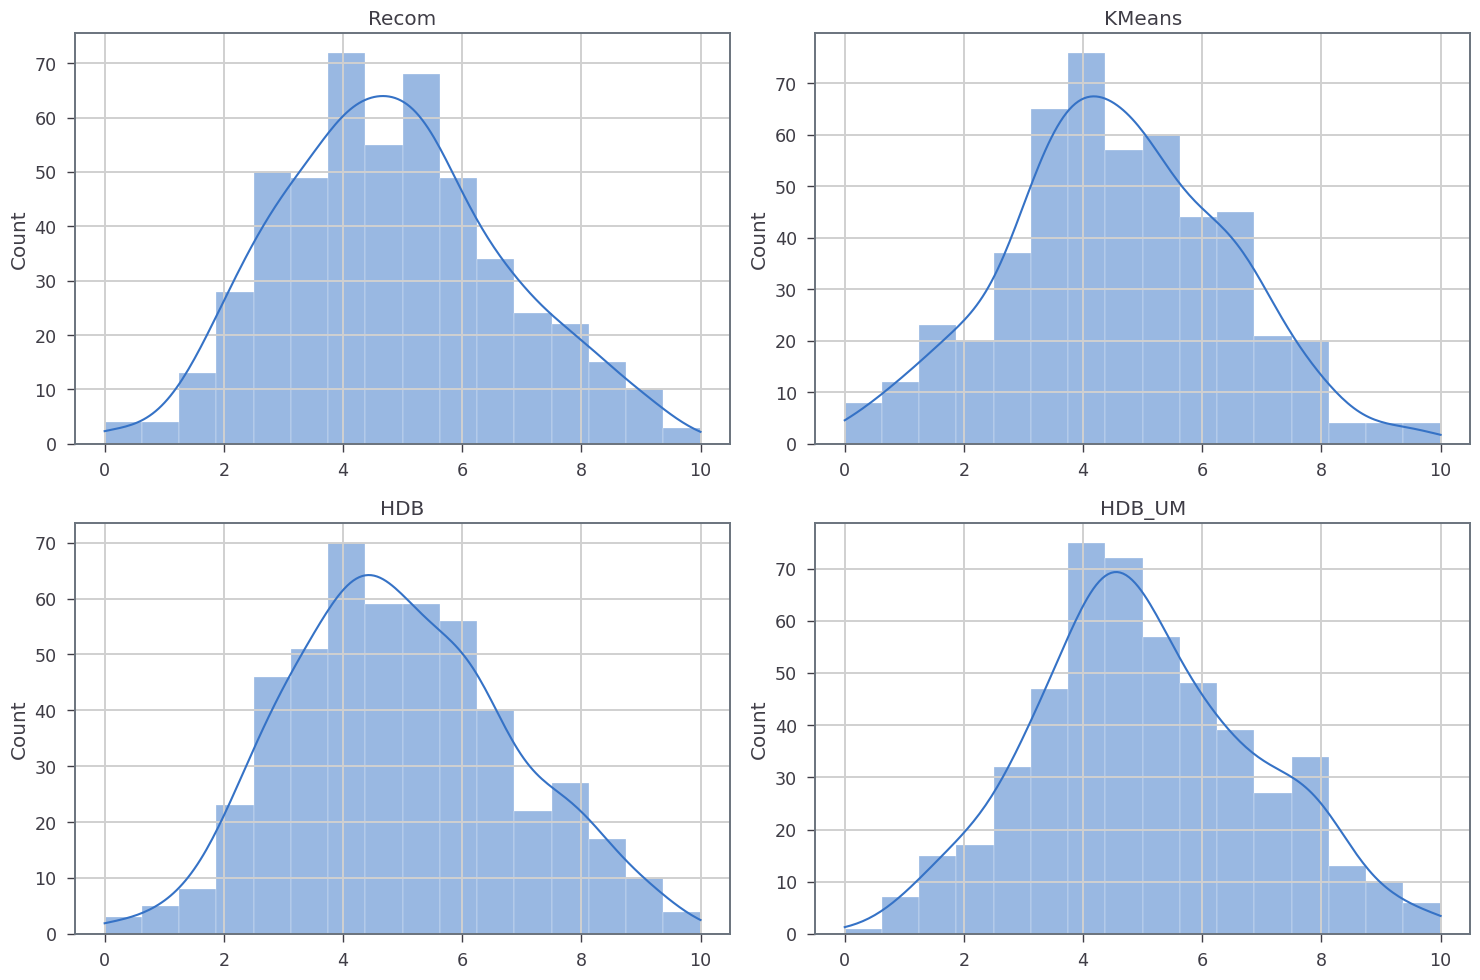

In [81]:
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=True)
from eval import plot_model_histograms_sns
fig = plot_model_histograms_sns(data_series)
fig.show()

In [82]:
from eval import test_normality
# Call the function with your data series
results_df = test_normality(recom, kmeans, hdb, hdb_um)
results_df

,Model,Statistics,P-Value,Normality
0,Model 1,0.992320,0.011259,Not Gaussian
1,Model 2,0.996420,0.327505,Gaussian
2,Model 3,0.992466,0.012694,Not Gaussian
3,Model 4,0.992062,0.009109,Not Gaussian


In [105]:
from eval import test_normality_kolmogorov

test_normality_kolmogorov(data_series)

,Model,Statistics,P-Value,Normality
0,Recom,0.931250,0.0,Not Gaussian
1,KMeans,0.898623,0.0,Not Gaussian
2,HDB,0.943250,0.0,Not Gaussian
3,HDB_UM,0.927250,0.0,Not Gaussian


When we're comparing two recommender systems that utilize semantic embeddings—say, one based on graph neural networks and another using a more traditional matrix factorization approach—the distributions of their performance metrics might not adhere to the assumptions required for parametric statistical tests. The Mann-Whitney U test comes in handy here as it doesn't assume a normal distribution and is instead based on the ranks of the data. 

In [107]:
from eval import perform_mann_whitney_tests
vector_names = ['Recommender', 'KMeans', 'HDB', 'HDB_UMAP']
mann_whitney_results_df = perform_mann_whitney_tests(recom, kmeans, hdb, hdb_um, model_names=vector_names)
mann_whitney_results_df

,Comparison,U-statistic,P-value,Significance
0,Recommender vs. KMeans,132425.0,0.103975,Not Significant
1,Recommender vs. HDB,119157.5,0.200781,Not Significant
2,Recommender vs. HDB_UMAP,116532.0,0.063699,Not Significant
3,KMeans vs. HDB,111834.5,0.003939,Significant
4,KMeans vs. HDB_UMAP,108822.5,0.000396,Significant
5,HDB vs. HDB_UMAP,122193.0,0.538825,Not Significant


If the p-value is less than the chosen significance level (commonly α = 0.05), you reject the null hypothesis. This outcome suggests that there is sufficient evidence to say there is a significant difference in the performance of the two recommender models, supporting the alternative hypothesis (H1).
If the p-value is greater than or equal to the significance level, you fail to reject the null hypothesis. This outcome means there isn't enough evidence to conclude a significant difference in the performance scores between the two models.
The Mann-Whitney U test indicates that the Recommender, HDB, and HDB_UMAP models' performances are statistically indistinguishable, whereas KMeans significantly differs from HDB and HDB_UMAP, suggesting distinct recommendation quality between these models.

In [114]:
from scipy.stats import friedmanchisquare, wilcoxon
stat, p = friedmanchisquare(recom, kmeans, hdb, hdb_um)

friedman_result = pd.DataFrame({
    'Test Statistic': [stat],
    'p-value': [p]
})

friedman_result

,Test Statistic,p-value
0,41.249648,5.788588e-09


Since the p-value is less than the typical alpha level of 0.05, we reject the null hypothesis of the Friedman test, which states that all algorithms perform equally well. This result indicates there are significant differences in performance between the recommender models. 

In [117]:
from scipy.stats import wilcoxon
scores = [recom, kmeans, hdb, hdb_um]
model_names = ['Recommender', 'KMeans', 'HDB', 'HDB_UMAP']

wilcoxon_results_list = []
# Perform pairwise Wilcoxon signed-rank tests
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        stat, p = wilcoxon(scores[i], scores[j])
        comparison_name = f'{model_names[i]} vs. {model_names[j]}'
        wilcoxon_results_list.append({'Comparison': comparison_name, 'Statistic': stat,'P-Value': p})

wilcoxon_results_df = pd.DataFrame(wilcoxon_results_list)
wilcoxon_results_df

,Comparison,Statistic,P-Value
0,Recommender vs. KMeans,53421.0,1.017638e-01
1,Recommender vs. HDB,3.0,1.677696e-22
2,Recommender vs. HDB_UMAP,32396.5,4.053178e-06
3,KMeans vs. HDB,45126.5,1.923494e-05
4,KMeans vs. HDB_UMAP,43765.5,3.253835e-06
5,HDB vs. HDB_UMAP,33846.5,2.730106e-01


In summary, the Recommender system seems to perform significantly different compared to both HDB and HDB_UMAP models. KMeans also shows a significant performance difference when compared to HDB and HDB_UMAP. However, no significant difference is detected between HDB and HDB_UMAP models and the Recommender and KMeans models.

In [118]:
from eval import calculate_rbo, compare_model_scores

scores = [recom, kmeans, hdb, hdb_um]
model_names = ['Recommender', 'KMeans', 'HDB', 'HDB_UMAP']
results_df = compare_model_scores(scores, model_names)
results_df

,Model Pair,RBO Score,Kendall’s Tau,P-value
0,Recommender vs KMeans,0.035629,0.489504,1.775963e-59
1,Recommender vs HDB,0.724792,0.928565,3.125471e-209
2,Recommender vs HDB_UMAP,0.424094,0.609992,2.065977e-91
3,KMeans vs HDB,0.047672,0.480105,2.810628e-57
4,KMeans vs HDB_UMAP,0.079044,0.407172,1.088922e-41
5,HDB vs HDB_UMAP,0.337710,0.620977,1.185385e-94


RBO Score: Measures the overlap between two rankings, with higher scores indicating greater similarity. A high RBO score between two models suggests they rank their recommendations similarly.

Kendall’s Tau: A measure of the correlation between two rankings. A Tau close to 1 indicates a strong positive correlation, meaning the models rank items similarly. A Tau close to -1 suggests a strong negative correlation, indicating the models rank items oppositely. A Tau close to 0 indicates no correlation.

P-value: Determines the statistical significance of Kendall’s Tau. A p-value below 0.05 typically indicates that the observed correlation (or lack thereof) is statistically significant.

In summary, the Recommender system shows significant alignment with the HDB model in terms of ranking recommended papers, as indicated by both RBO and Kendall’s Tau. There is also moderate alignment with HDB_UMAP. The KMeans model, however, has significantly different rankings compared to HDB and HDB_UMAP. Lastly, HDB and HDB_UMAP exhibit a strong positive correlation in their rankings, indicating that the addition of UMAP maintains a strong relationship in the order of recommendations.

## Conclusions

The evaluation of models for semantic clustering of arXiv papers, including a basic recommender system, KMeans, HDBSCAN, and HDBSCAN with UMAP, was rigorously conducted using normalized scores and a suite of statistical tests without true labels. KMeans clustering demonstrated the highest performance, attributed to its effective handling of high-dimensional data and capability to group semantically similar papers, which facilitated relevant recommendations. The integration of UMAP with HDBSCAN followed closely, highlighting the benefits of dimensionality reduction in enhancing cluster quality by preserving data's local and global structure. However, it slightly lagged behind KMeans, suggesting a trade-off between complexity and performance.

The basic recommender, relying on embedding-based similarity, provided strong baseline results, underscoring the value of semantic embeddings in capturing paper content. Conversely, HDBSCAN alone showed the lowest performance, indicating the necessity of dimensionality reduction or hyperparameter tuning to achieve optimal clustering outcomes.

Statistical analyses, including MAE, Euclidean Distance, Spearman Correlation, T-tests, Mann-Whitney, Friedman, Nemenyi, and Wilcoxon signed-rank tests, alongside RBO scores and Kendall’s Tau, offered comprehensive insights into model comparisons. These tests were crucial for understanding the statistical significance of performance differences and models' rank-ordering capabilities.

The evaluation process highlighted the importance of model selection and optimization in unsupervised learning scenarios, especially in the absence of true labels. It underscored the need for careful hyperparameter tuning and the potential of combining clustering techniques with dimensionality reduction methods like UMAP to improve semantic clustering. Ultimately, KMeans emerged as the most effective model based on its superior normalized score and statistical test outcomes, demonstrating its robustness and efficiency in semantic paper recommendation tasks.